# 3. Model Training 

In [ ]:
# import numpy for math calculations
import numpy as np

# import pandas for data (csv) manipulation
import pandas as pd

# import matplotlib for plotting
import matplotlib.pyplot as plt

import sys  
sys.path.insert(1, '../src/user_identification')

from train_model import ClassifierEvaluator
from visualize import VisualizationUtils

# import shap for ai explainability
import shap

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import tree

# import warnings to hide the unnessairy warniings
import warnings
warnings.filterwarnings('ignore')

c:\Users\Benhamadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mov_slow = pd.read_csv('../data/processed/movement_slow_stat_cleaned.csv').drop(columns=['Unnamed: 0']).fillna(0)
mov_fast = pd.read_csv('../data/processed/movement_fast_stat_cleaned.csv').drop(columns=['Unnamed: 0']).fillna(0)
traffic_slow = pd.read_csv('../data/processed/traffic_slow_stat_cleaned.csv', index_col=0).fillna(0)
traffic_fast = pd.read_csv('../data/processed/traffic_fast_stat_cleaned.csv', index_col=0).fillna(0)

In [3]:
for col in mov_fast.columns.values:
    if "PosY" in col and "Accel" not in col and "Velocity" not in col:
        print(col)
        for id in range(60):
            #print(id, col, mov_fast.loc[mov_fast['ID'] == id][col])
            print(id, col, np.mean(mov_fast.loc[mov_fast['ID'] == id,col]), np.max(mov_fast.loc[mov_fast['ID'] == id,col]), np.min(mov_fast.loc[mov_fast['ID'] == id,col]))
            mov_fast.loc[mov_fast['ID'] == id,col] = mov_fast.loc[mov_fast['ID'] == id,col] / np.mean(mov_fast.loc[mov_fast['ID'] == id,col])
            print(id, col, np.mean(mov_fast.loc[mov_fast['ID'] == id,col]), np.max(mov_fast.loc[mov_fast['ID'] == id,col]), np.min(mov_fast.loc[mov_fast['ID'] == id,col]))
            mov_slow.loc[mov_slow['ID'] == id,col] = mov_slow.loc[mov_slow['ID'] == id,col] / np.mean(mov_fast.loc[mov_fast['ID'] == id,col])

HeadPosY_25%
0 HeadPosY_25% 0.7134620286105323 0.7278551096508605 0.6570334403533158
0 HeadPosY_25% 0.9999999999999999 1.0201735768171976 0.9209087716032888
1 HeadPosY_25% 0.7788999002622312 0.8124401626932196 0.2526097097609505
1 HeadPosY_25% 0.9999999999999998 1.0430610691048958 0.3243160124630966
2 HeadPosY_25% 0.9066900340050817 0.9214591842635648 0.7479711538667484
2 HeadPosY_25% 1.0000000000000002 1.0162890841462588 0.824946923220021
3 HeadPosY_25% 0.8121922818530807 0.8303501245472713 0.7458421772961998
3 HeadPosY_25% 1.0 1.0223565811937563 0.918307393409972
4 HeadPosY_25% 0.8161531278178419 0.8245928921311398 0.7965606533430714
4 HeadPosY_25% 1.0 1.0103409078831365 0.9759941194771192
5 HeadPosY_25% 0.8564253755159127 0.9103195392500604 0.7888929107650393
5 HeadPosY_25% 0.9999999999999999 1.0629291999920971 0.9211461188779096
6 HeadPosY_25% 0.8777812166008767 0.8872263547594619 0.8320635865758819
6 HeadPosY_25% 1.0 1.0107602418233106 0.9479168280656176
7 HeadPosY_25% 0.857940040

In [4]:
evaluator = ClassifierEvaluator()
X, y, fX, fy, X_train, y_train, X_test, y_test, fX_train, fy_train, fX_test, fy_test = evaluator.split_data(mov_slow, mov_fast, id_range=None, train_minutes=8, test_minutes=2)

Size of the training set:  (2877, 462)
Size of the slow testing set:  (720, 462)
Size of the fast training set:  (2880, 462)
Size of the fast testing set:  (720, 462)


## 3.1. Movement Data
### 3.1.1. With Height Variables
To begin, we will attempt to predict users based on statistical features derived from their movement data. We will explore different time intervals and evaluate their impact on the accuracy of the results. Next, we will train machine learning models using data from slow-paced games and subsequently test their predictive capabilities on fast-paced games. This process will help us determine whether it is feasible to accurately predict user behavior in fast-paced games using models trained on slow-paced game data.

In [5]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(X_train,y_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Slow)').style.background_gradient(cmap= plt.cm.Blues)

100%|██████████| 15/15 [11:43<00:00, 46.93s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),Precision(Train),Precision(Slow),Recall(Train),Recall(Slow),Log_loss(Train),Log_loss(Slow)
11,BernoulliNB,0.074383,0.045833,0.027778,0.074383,0.045833,0.074383,0.045833,0.074383,0.045833,3.962008,4.086871
7,AdaBoostClassifier,0.050400,0.054167,0.016667,0.050400,0.054167,0.050400,0.054167,0.050400,0.054167,3.329380,3.347972
9,QuadraticDiscriminantAnalysis,1.000000,0.066667,0.016667,1.000000,0.066667,1.000000,0.066667,1.000000,0.066667,0.000000,33.640743
0,SVC,0.641293,0.587500,0.025000,0.641293,0.587500,0.641293,0.587500,0.641293,0.587500,4.095009,4.094628
3,DecisionTreeClassifier,1.000000,0.713889,0.008333,1.000000,0.713889,1.000000,0.713889,1.000000,0.713889,0.000000,10.312490
8,GaussianNB,0.879388,0.718056,0.026389,0.879388,0.718056,0.879388,0.718056,0.879388,0.718056,3.374794,8.684258
4,KNeighborsClassifier,0.911018,0.733333,0.027778,0.911018,0.733333,0.911018,0.733333,0.911018,0.733333,0.238333,4.386543
2,LinearDiscriminantAnalysis,0.977059,0.769444,0.033333,0.977059,0.769444,0.977059,0.769444,0.977059,0.769444,0.125836,3.390243
12,BaggingClassifier,0.997567,0.820833,0.020833,0.997567,0.820833,0.997567,0.820833,0.997567,0.820833,0.090007,2.276795
6,MLPClassifier,0.979493,0.822222,0.037500,0.979493,0.822222,0.979493,0.822222,0.979493,0.822222,0.132908,0.695265


In [6]:
explainer = shap.TreeExplainer(best_model_slow)
shap_values_slow = explainer.shap_values(X_test)
shap_values_fast = explainer.shap_values(fX_test)

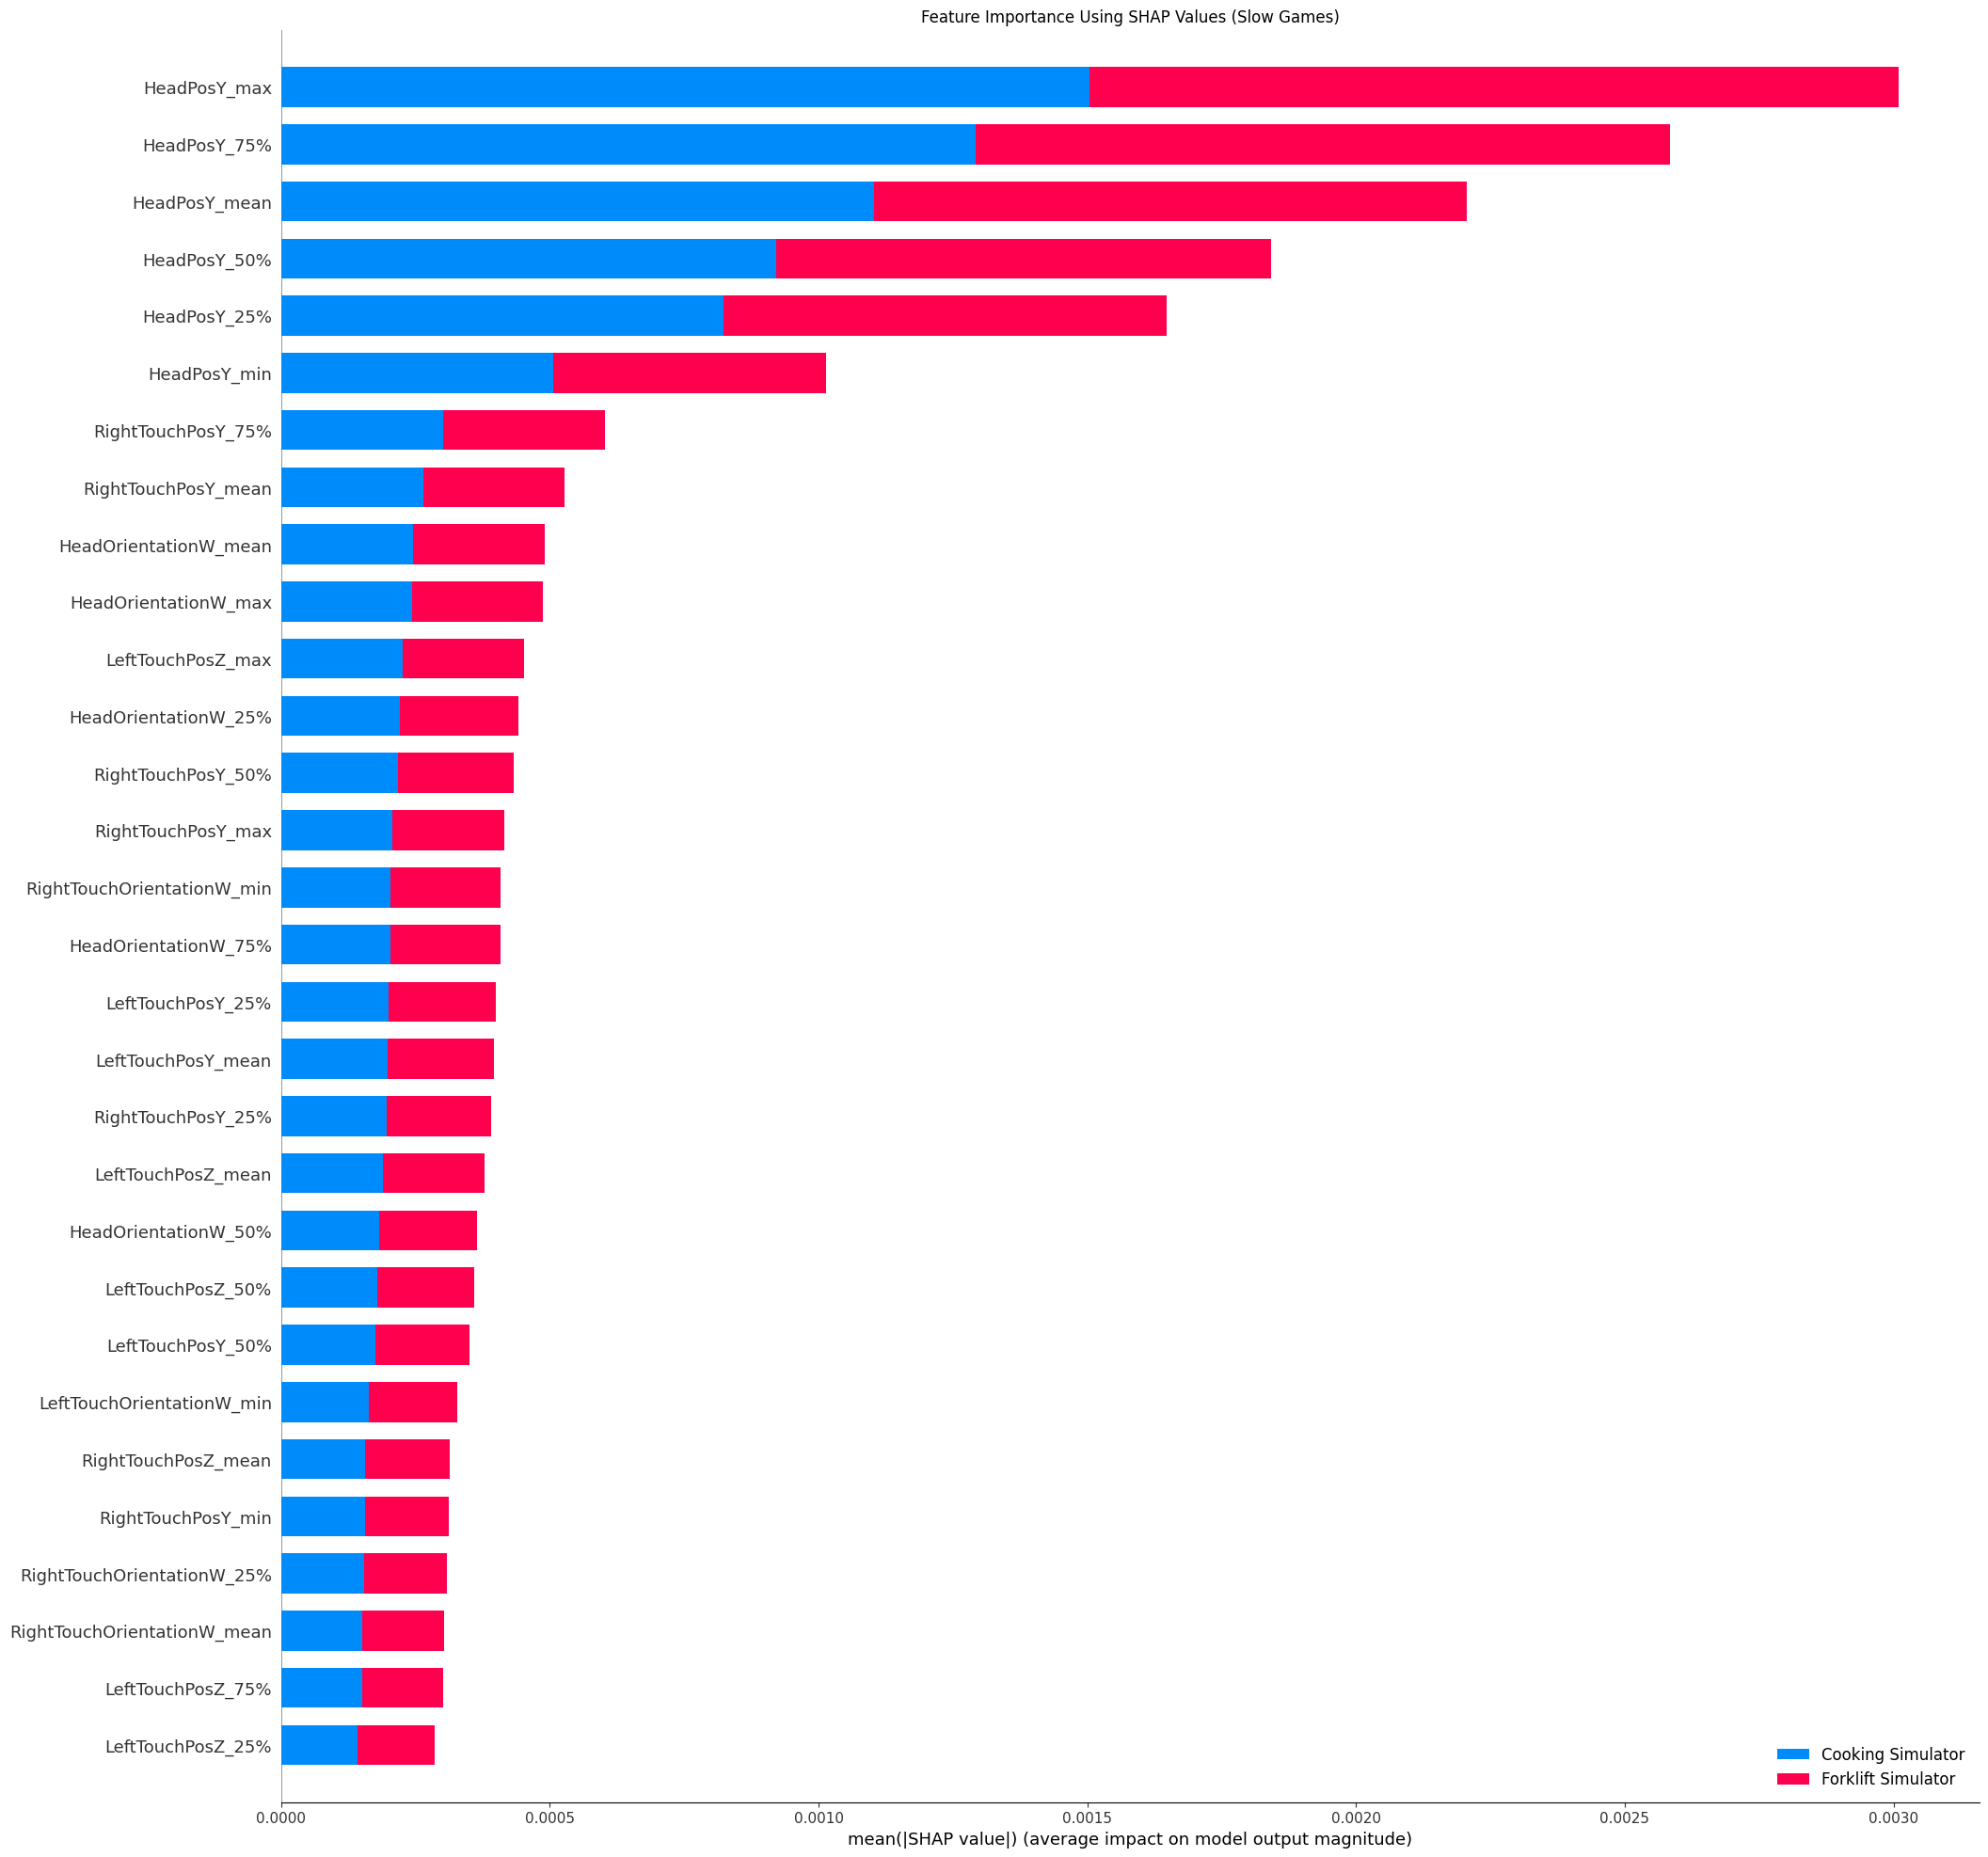

In [7]:
VisualizationUtils.shap_plotter([np.mean(shap_values_slow[:,:,:30], axis=2), np.mean(shap_values_slow[:,:,30:], axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (Slow Games)",
                          class_names=['Cooking Simulator', 'Forklift Simulator'])

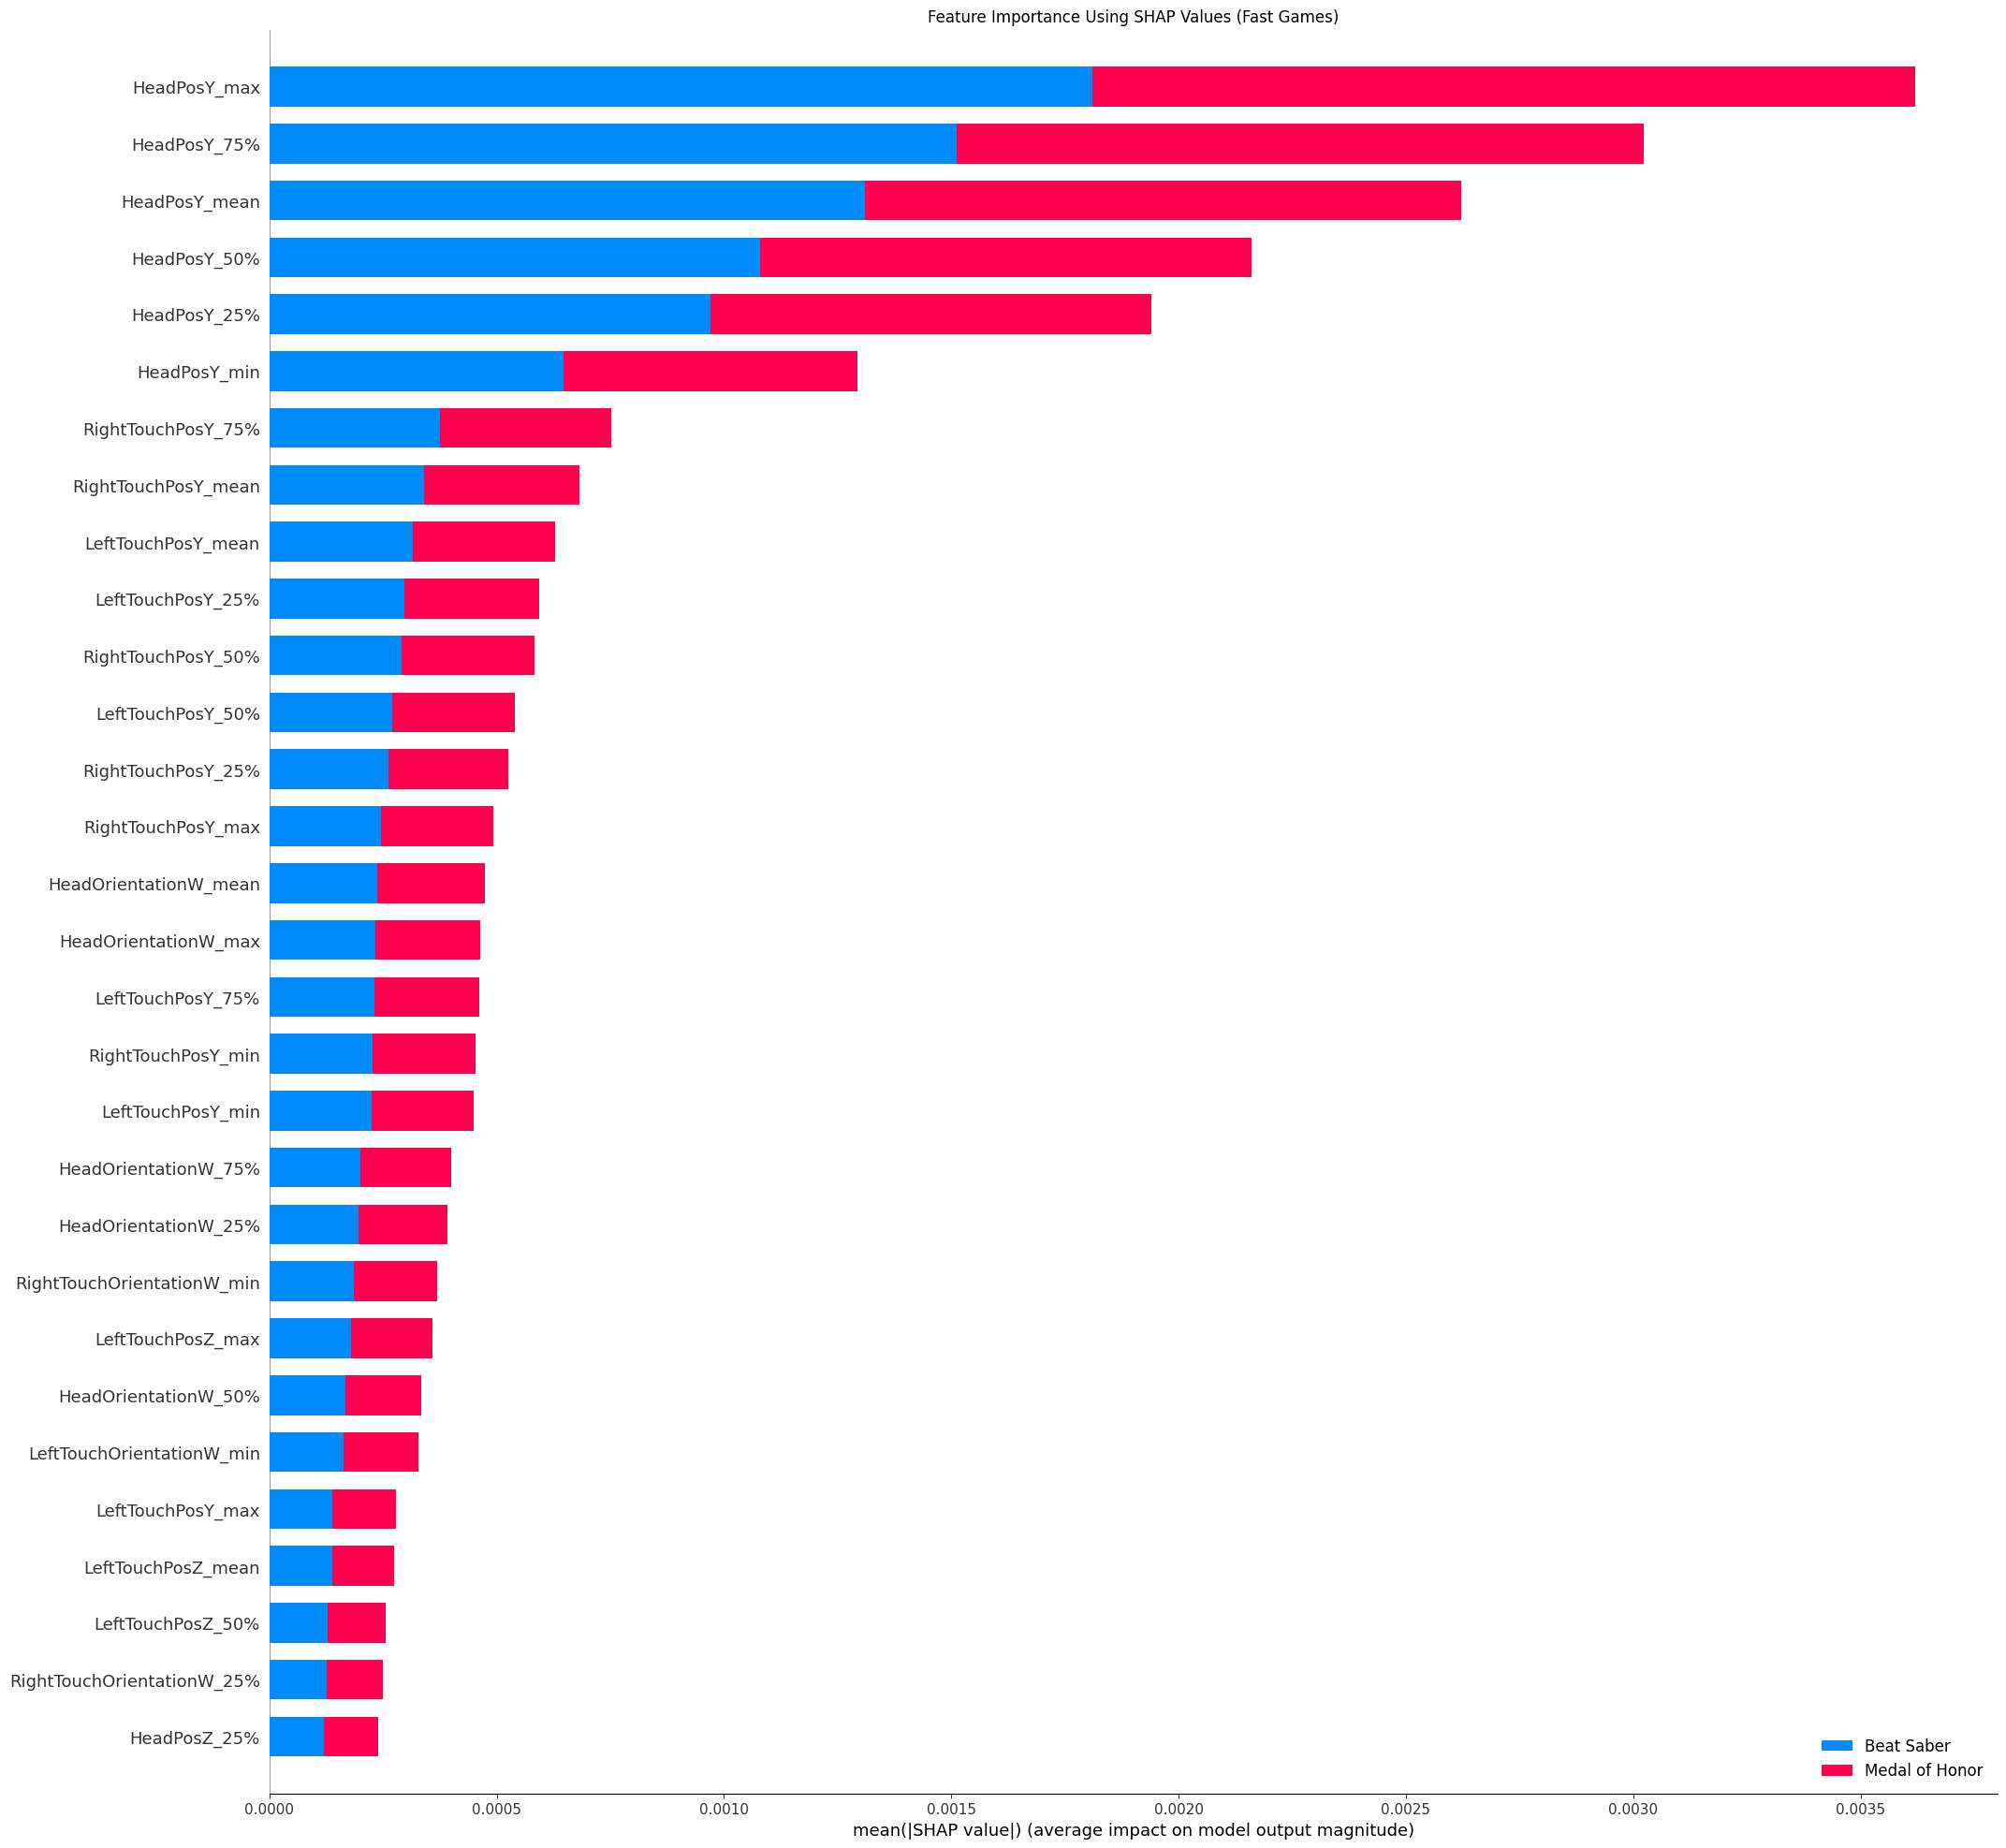

In [8]:
VisualizationUtils.shap_plotter([np.mean(shap_values_fast[:,:,:30], axis=2), np.mean(shap_values_fast[:,:,30:], axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (Fast Games)",
                          class_names=['Beat Saber', 'Medal of Honor'])

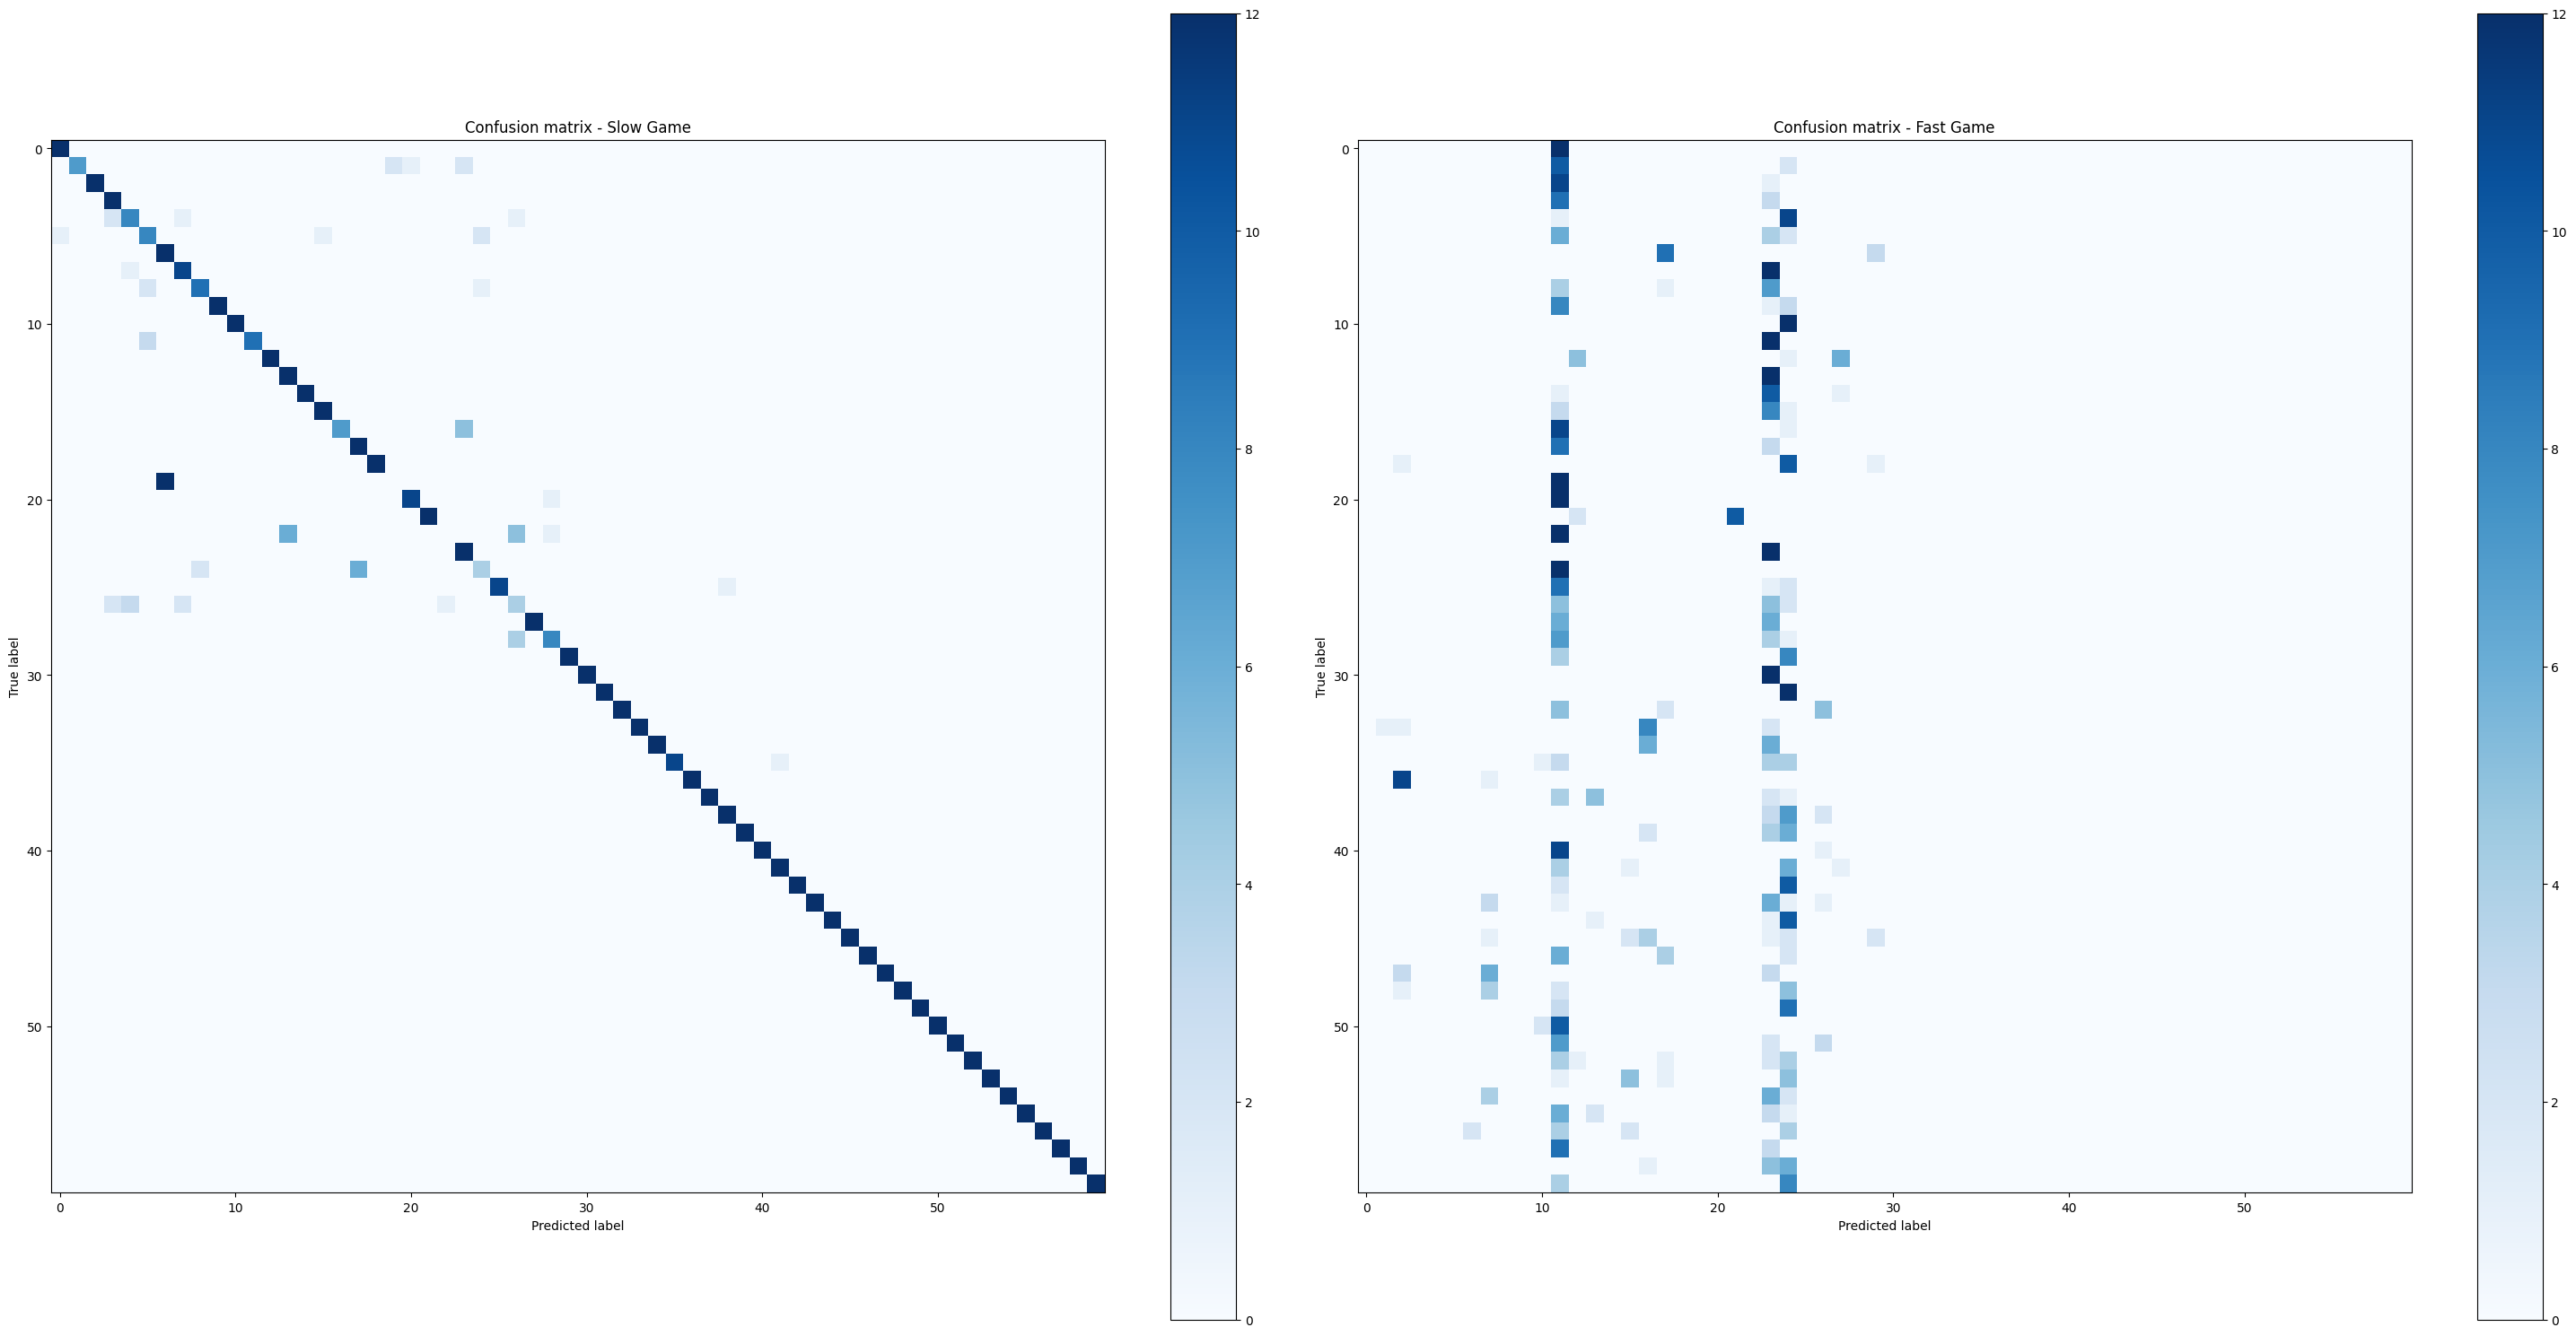

In [9]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

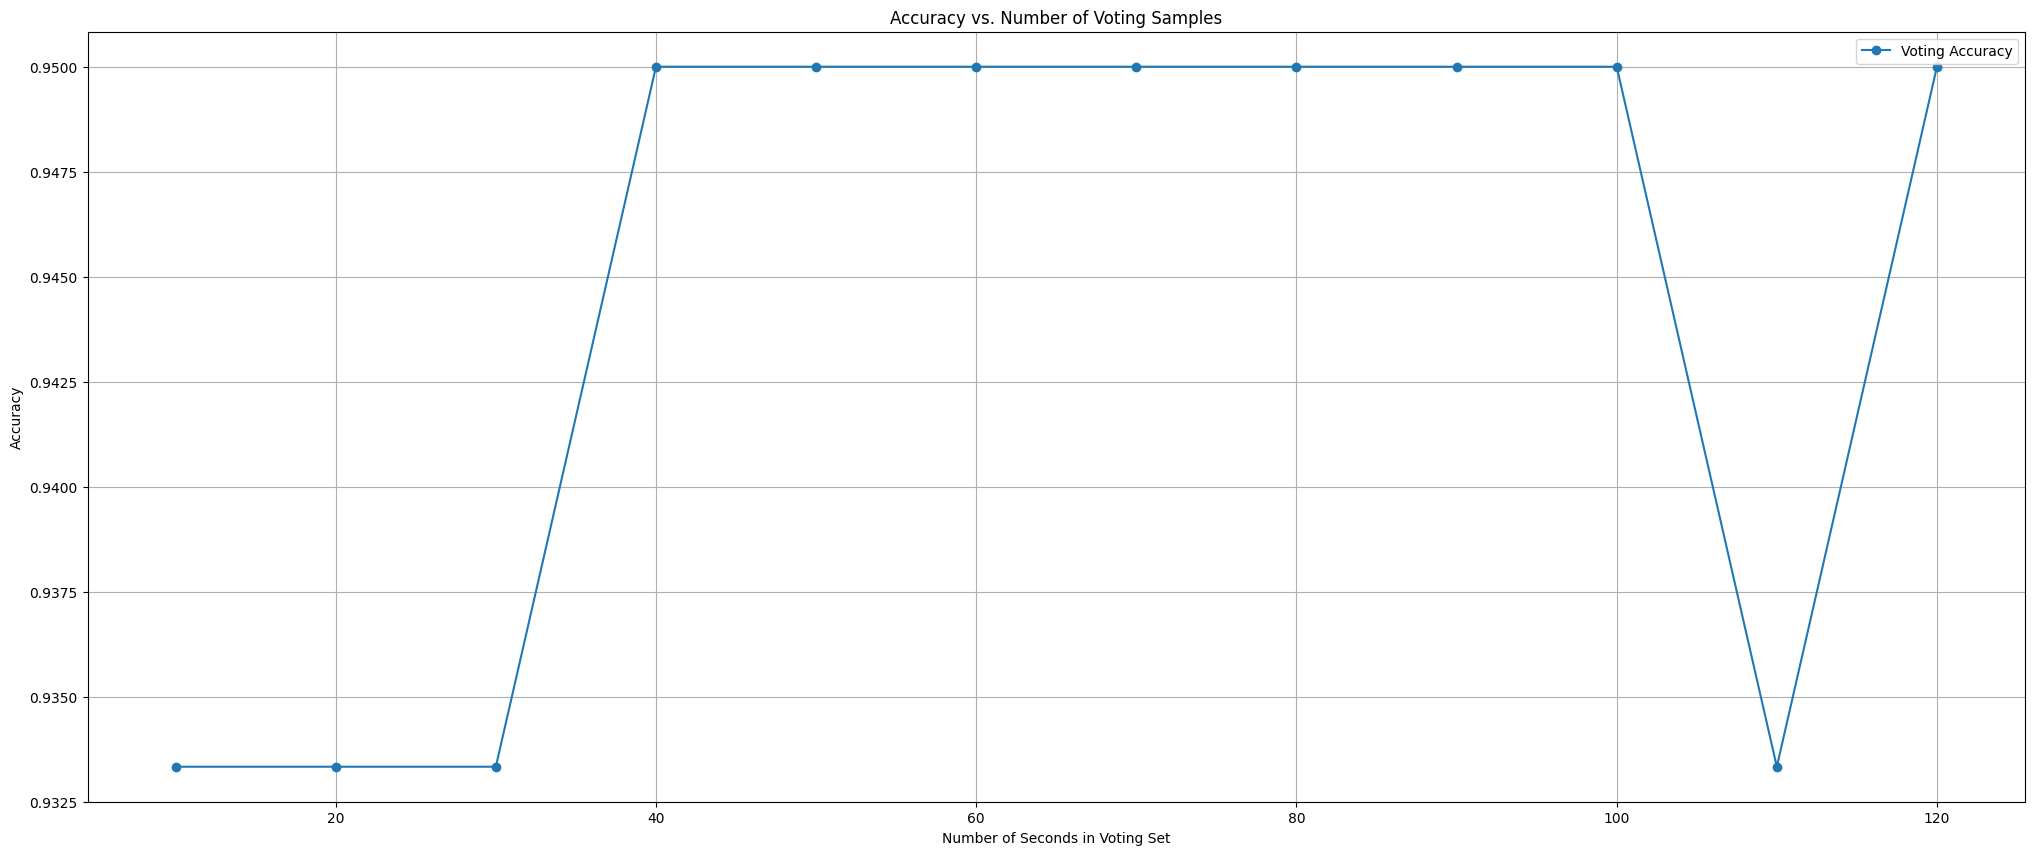


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.933333
1,20,0.933333
2,30,0.933333
3,40,0.950000
4,50,0.950000
5,60,0.950000
6,70,0.950000
7,80,0.950000
8,90,0.950000
9,100,0.950000


In [10]:
evaluator.plot_accuracy_by_vote(best_model_slow, X_test, y_test, increment=1)

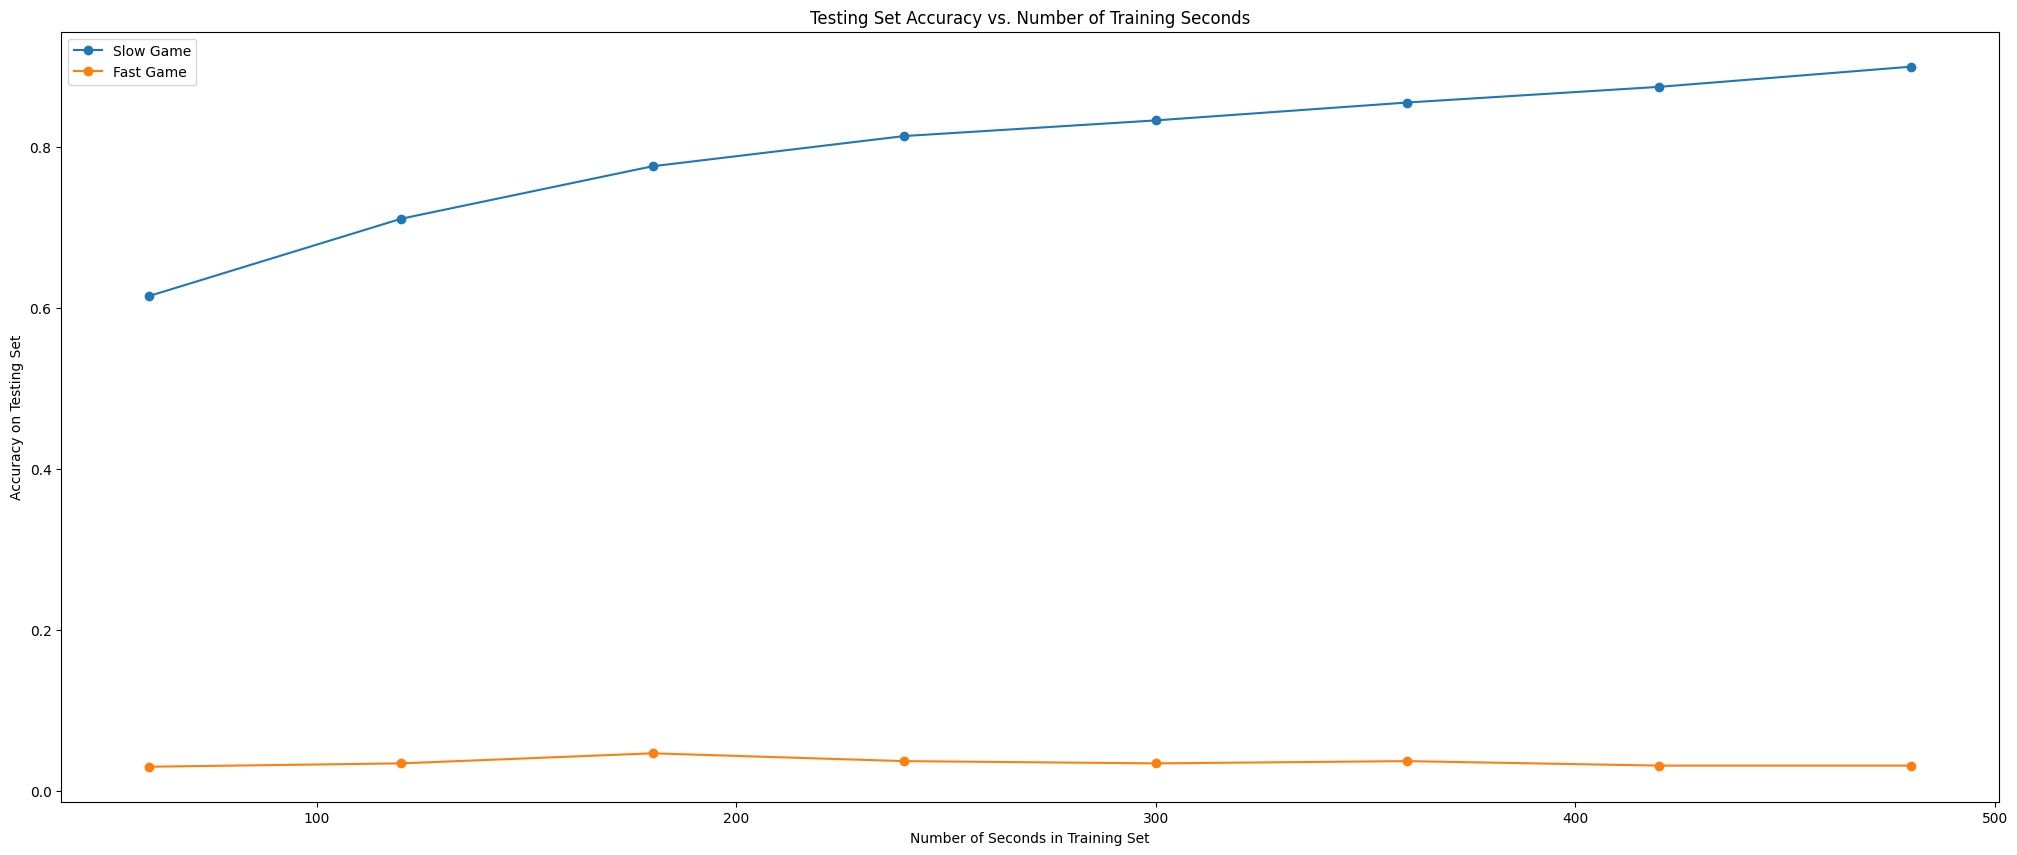


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.615278,0.030556
1,120,0.711111,0.034722
2,180,0.776389,0.047222
3,240,0.813889,0.037500
4,300,0.833333,0.034722
5,360,0.855556,0.037500
6,420,0.875000,0.031944
7,480,0.900000,0.031944


In [11]:
evaluator.accuracy_over_time(X, y,best_model_slow_name, range(1,9), X_test, y_test, fX_test, fy_test)

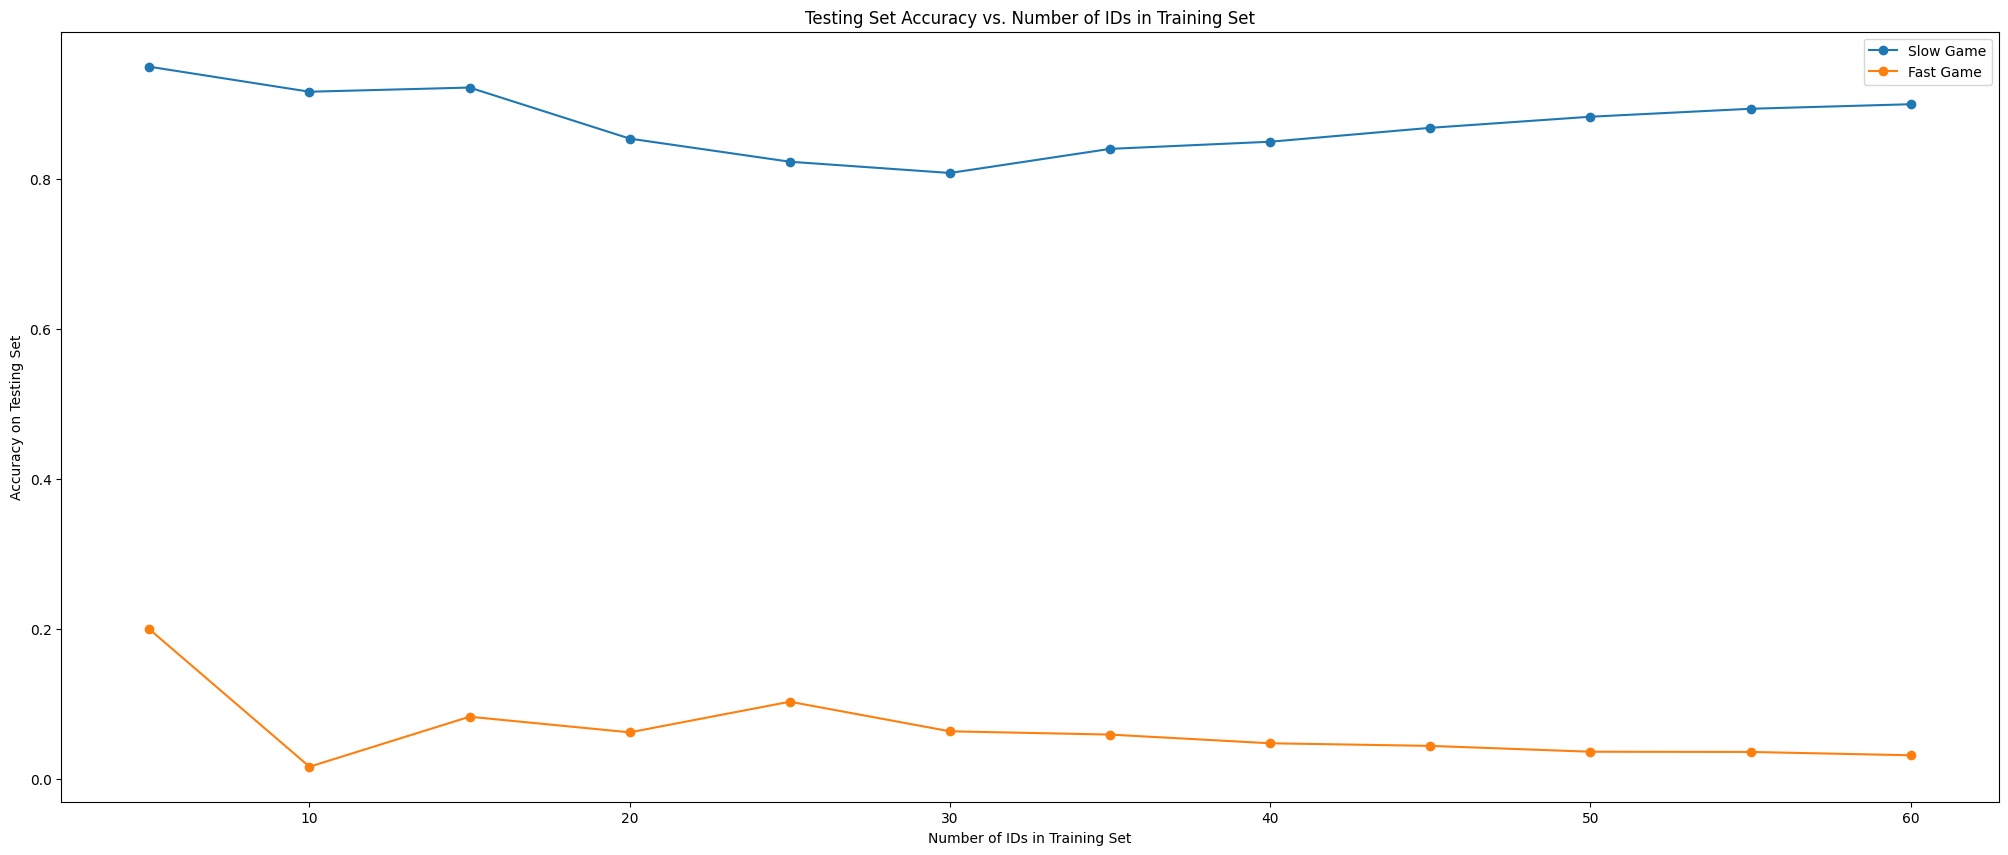


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,0.950000,0.200000
1,10,0.916667,0.016667
2,15,0.922222,0.083333
3,20,0.854167,0.062500
4,25,0.823333,0.103333
5,30,0.808333,0.063889
6,35,0.840476,0.059524
7,40,0.850000,0.047917
8,45,0.868519,0.044444
9,50,0.883333,0.036667


In [12]:
evaluator.accuracy_over_ids(X_train, y_train, best_model_slow_name,  X_test, y_test,fX_test, fy_test)

## 3.2. Traffic Data

In [13]:
X, y, fX, fy, X_train, y_train, X_test, y_test, fX_train, fy_train, fX_test, fy_test = evaluator.split_data(traffic_slow, traffic_fast, id_range=None, train_minutes=8, test_minutes=2)

Size of the training set:  (2879, 28)
Size of the slow testing set:  (720, 28)
Size of the fast training set:  (2880, 28)
Size of the fast testing set:  (720, 28)


In [15]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name= evaluator.evaluate_classifiers(X_train,y_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Slow)').style.background_gradient(cmap= plt.cm.Blues)

100%|██████████| 15/15 [03:43<00:00, 14.90s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),Precision(Train),Precision(Slow),Recall(Train),Recall(Slow),Log_loss(Train),Log_loss(Slow)
11,BernoulliNB,0.023272,0.018056,0.029167,0.023272,0.018056,0.023272,0.018056,0.023272,0.018056,4.069689,4.082240
0,SVC,0.174713,0.051389,0.079167,0.174713,0.051389,0.174713,0.051389,0.174713,0.051389,3.917400,3.937200
7,AdaBoostClassifier,0.067385,0.066667,0.066667,0.067385,0.066667,0.067385,0.066667,0.067385,0.066667,3.749903,3.781773
4,KNeighborsClassifier,0.690518,0.191667,0.101389,0.690518,0.191667,0.690518,0.191667,0.690518,0.191667,0.798197,17.537538
10,LogisticRegression,0.351164,0.306944,0.108333,0.351164,0.306944,0.351164,0.306944,0.351164,0.306944,2.934599,2.857233
3,DecisionTreeClassifier,1.000000,0.370833,0.140278,1.000000,0.370833,1.000000,0.370833,1.000000,0.370833,0.000000,22.677465
1,ExtraTreesClassifier,1.000000,0.458333,0.095833,1.000000,0.458333,1.000000,0.458333,1.000000,0.458333,0.000000,2.029526
12,BaggingClassifier,0.989580,0.475000,0.148611,0.989580,0.475000,0.989580,0.475000,0.989580,0.475000,0.236871,7.248439
8,GaussianNB,0.607155,0.487500,0.019444,0.607155,0.487500,0.607155,0.487500,0.607155,0.487500,2.078523,3.574382
6,MLPClassifier,0.598472,0.511111,0.066667,0.598472,0.511111,0.598472,0.511111,0.598472,0.511111,1.703447,1.731563


In [16]:
explainer = shap.TreeExplainer(models[13][2])
shap_values_slow = explainer.shap_values(X_test)
shap_values_fast = explainer.shap_values(fX_test)

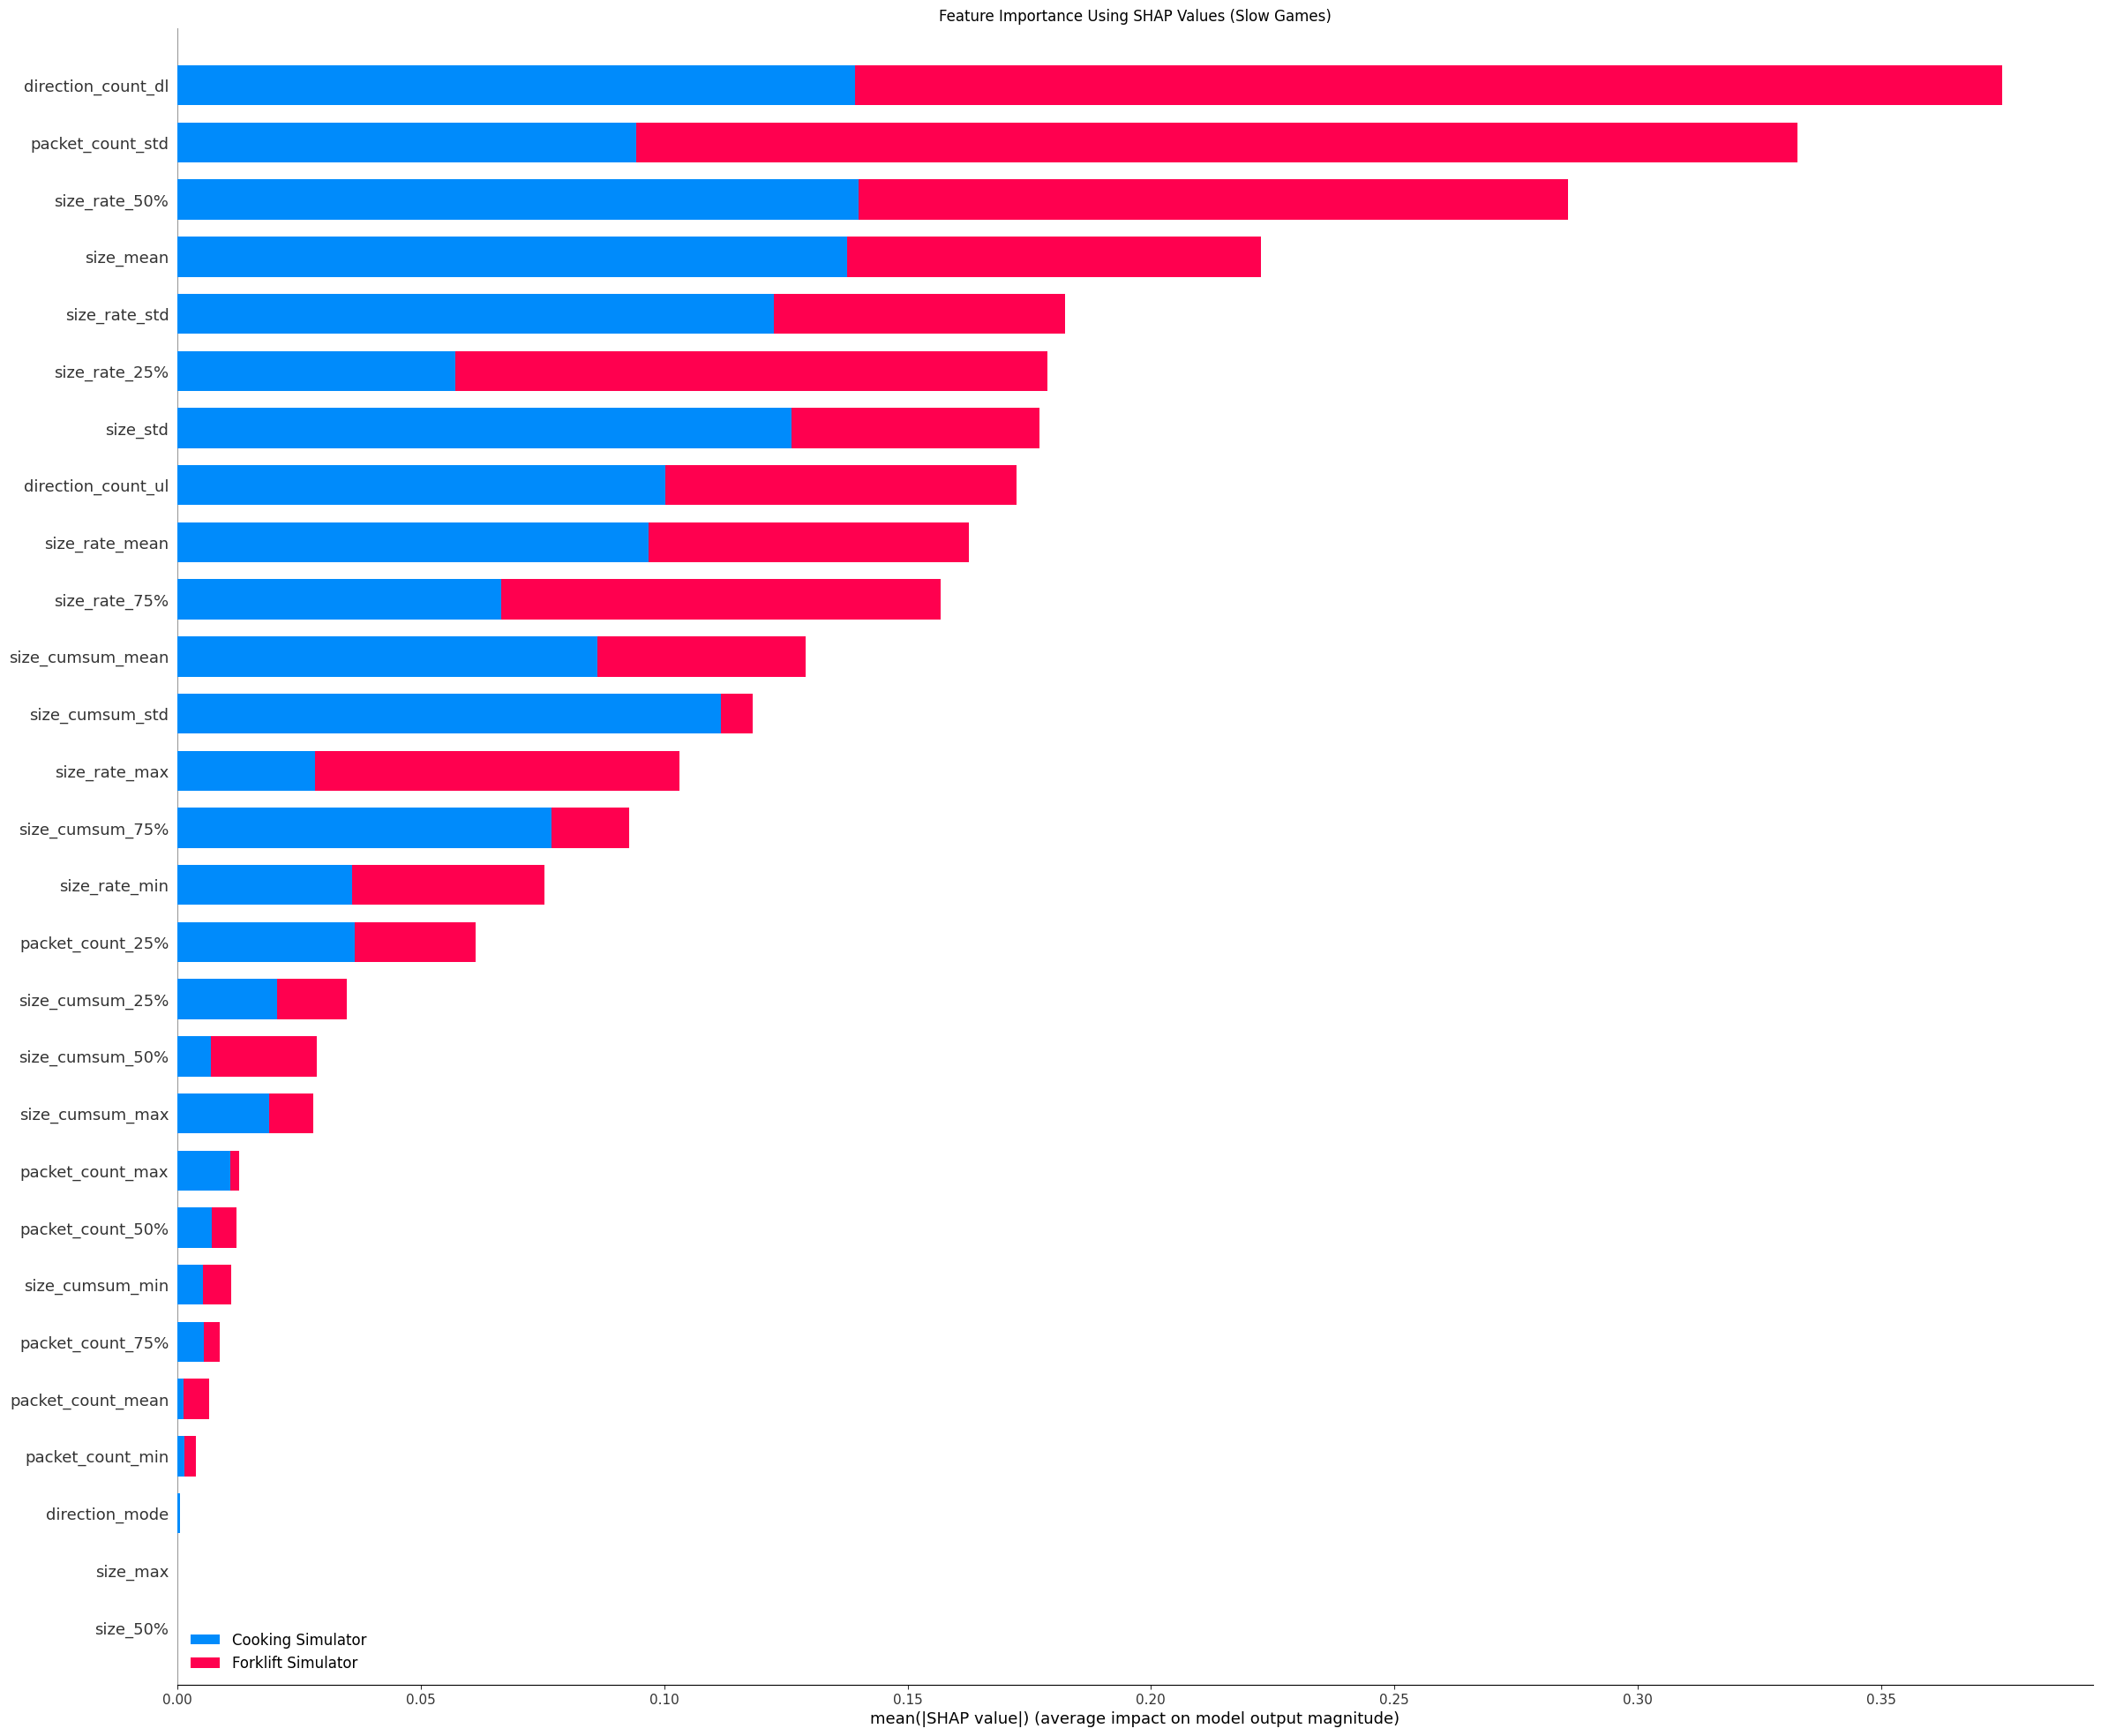

In [17]:
VisualizationUtils.shap_plotter([np.mean(shap_values_slow[:,:,:30], axis=2), np.mean(shap_values_slow[:,:,30:], axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (Slow Games)",
                          class_names=['Cooking Simulator', 'Forklift Simulator'])

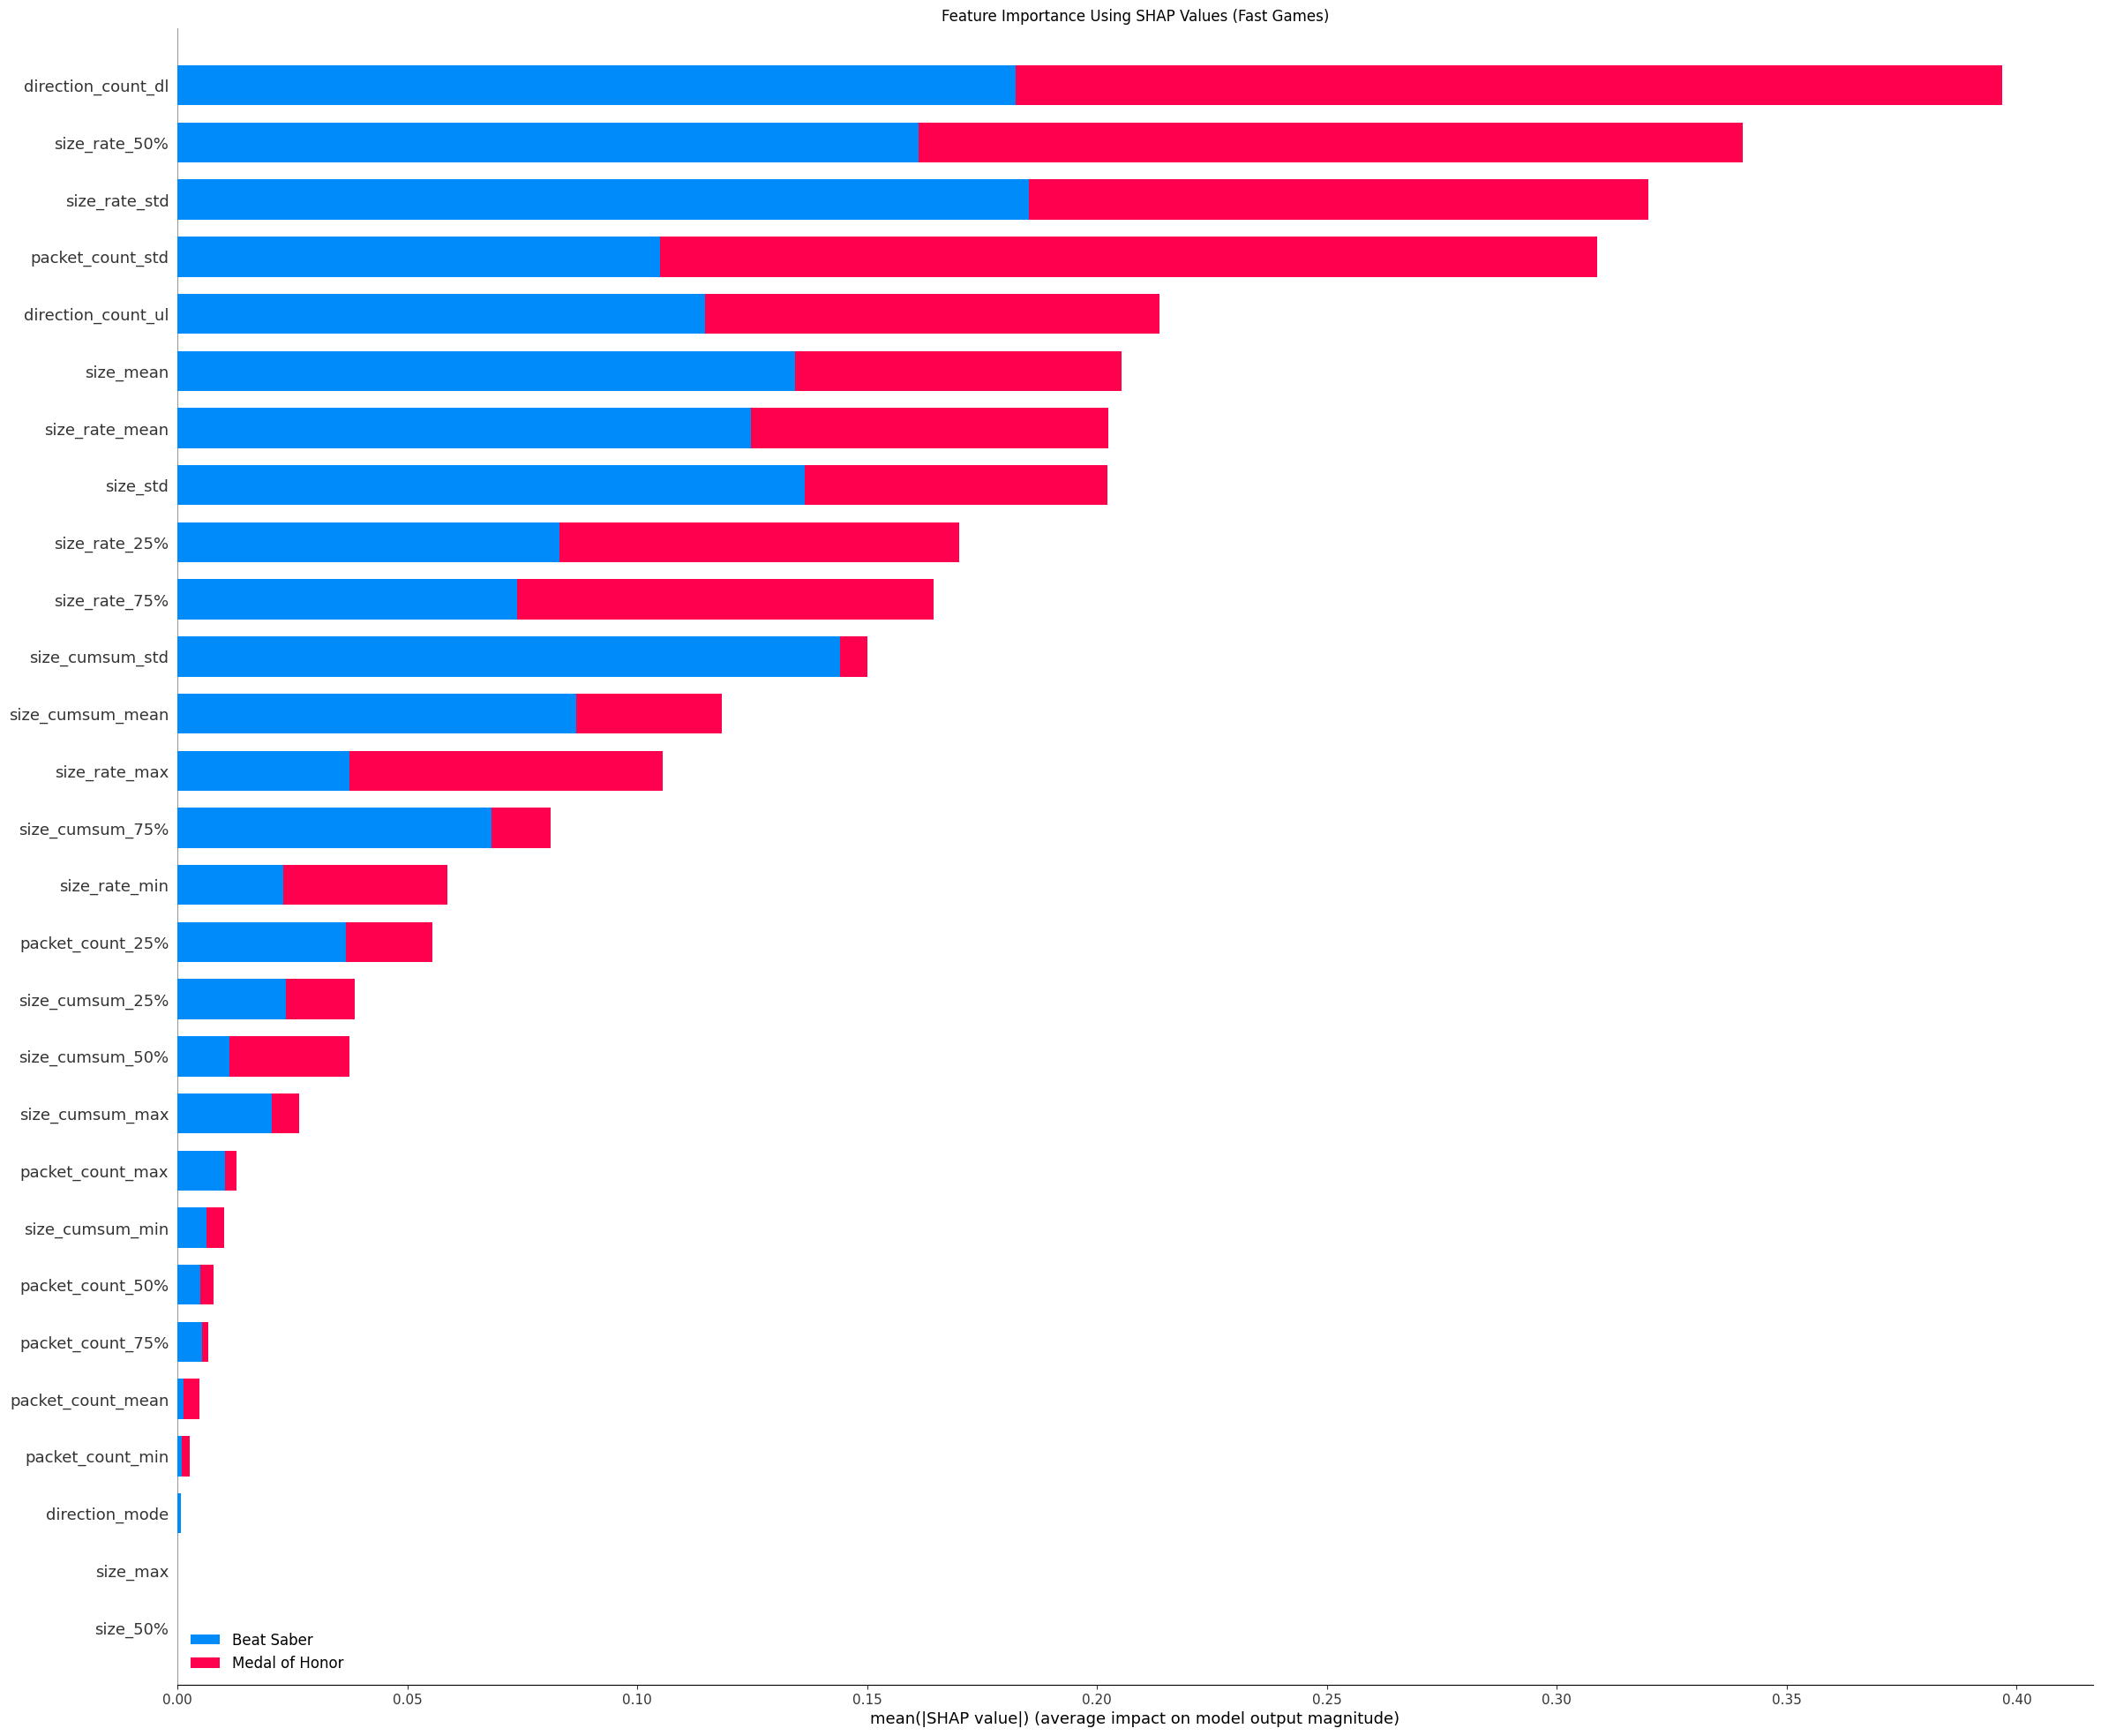

In [18]:
VisualizationUtils.shap_plotter([np.mean(shap_values_fast[:,:,:30], axis=2), np.mean(shap_values_fast[:,:,30:], axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (Fast Games)",
                          class_names=['Beat Saber', 'Medal of Honor'])

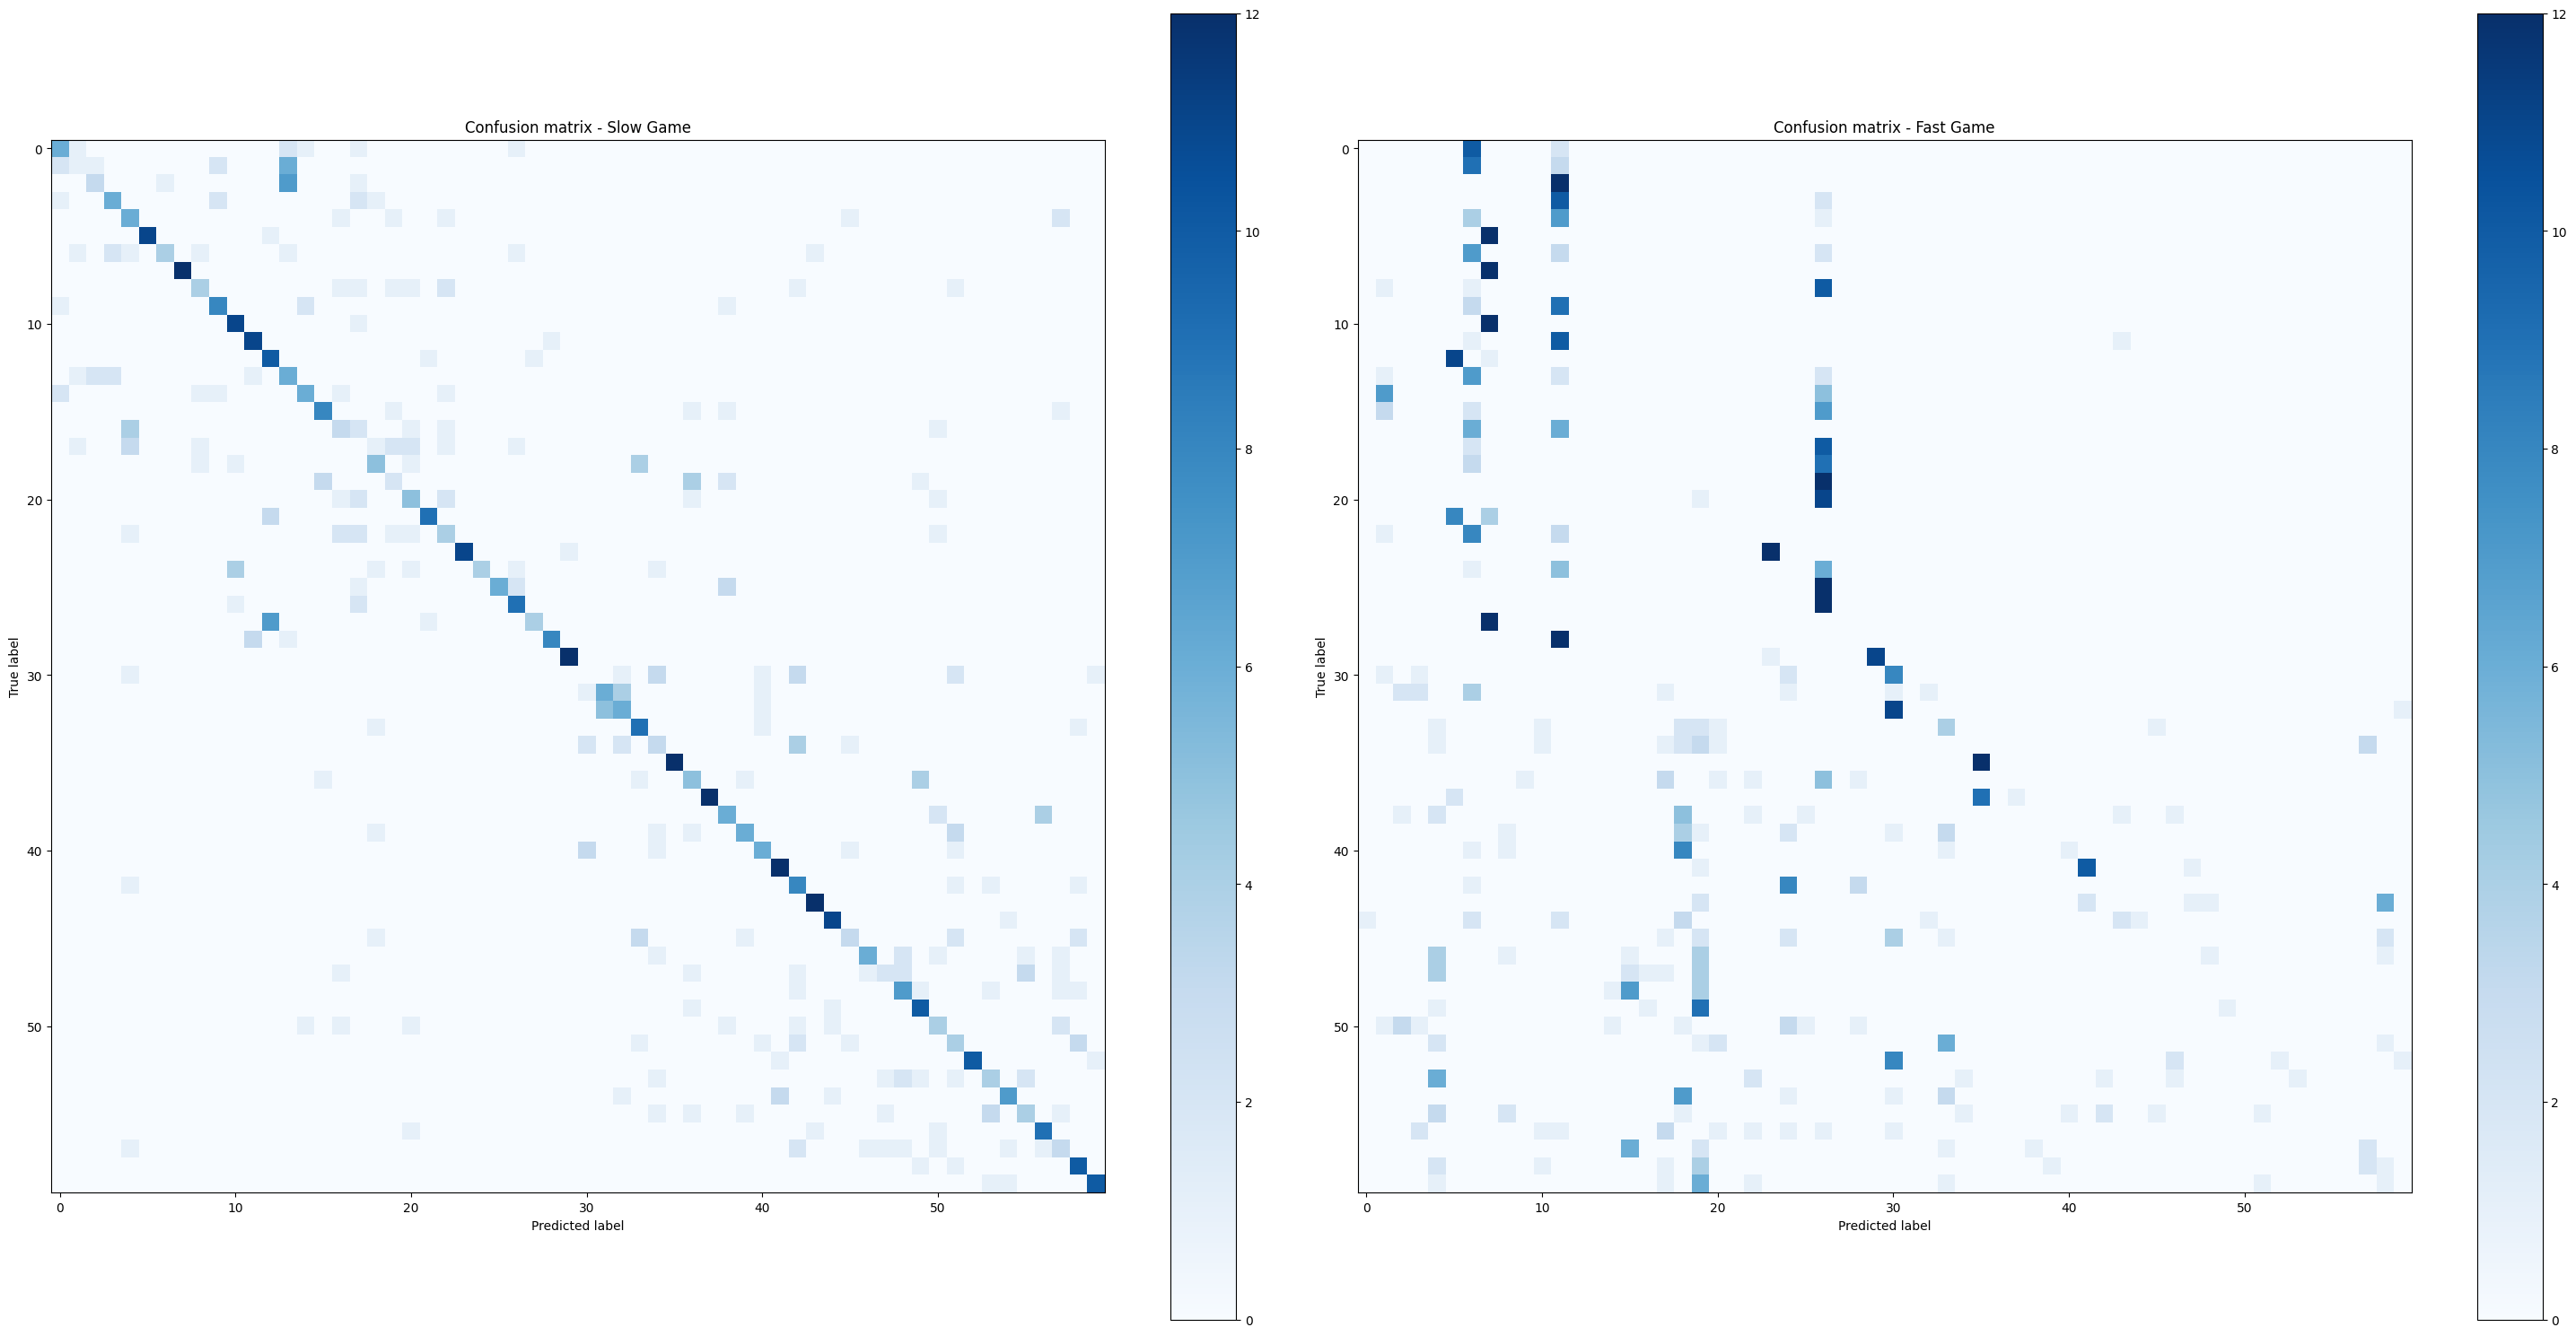

In [19]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

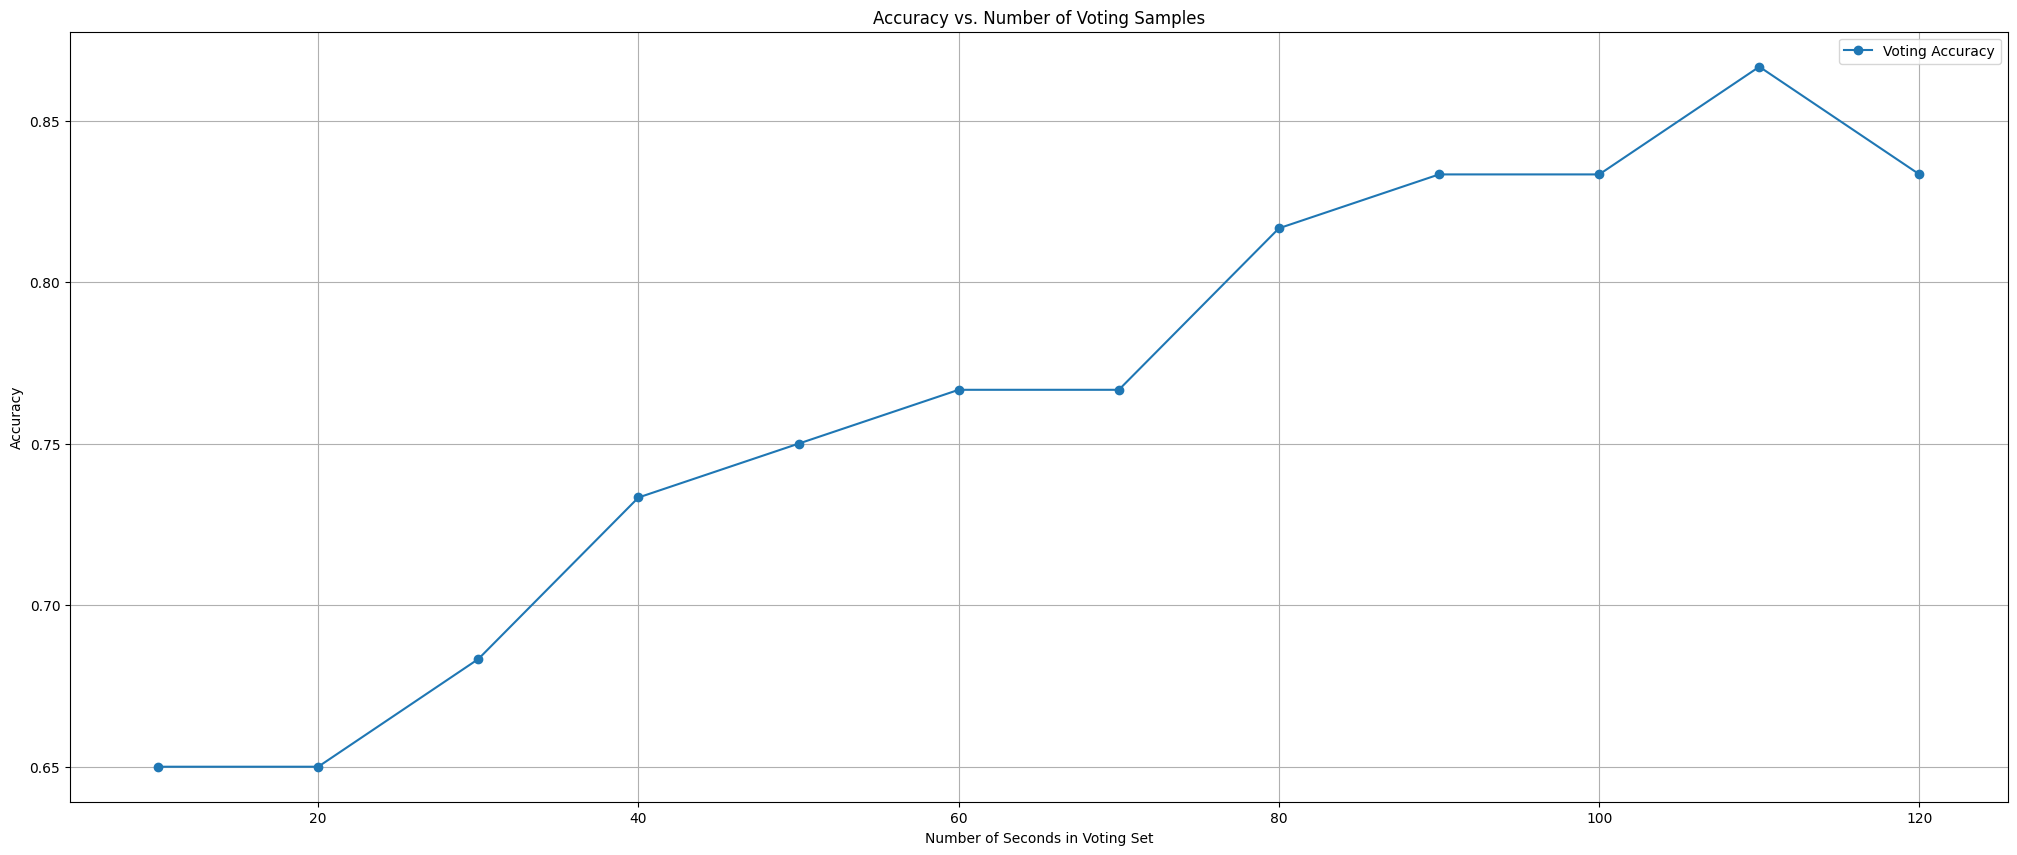


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.650000
1,20,0.650000
2,30,0.683333
3,40,0.733333
4,50,0.750000
5,60,0.766667
6,70,0.766667
7,80,0.816667
8,90,0.833333
9,100,0.833333


In [20]:
evaluator.plot_accuracy_by_vote(best_model_slow, X_test, y_test, increment=1)

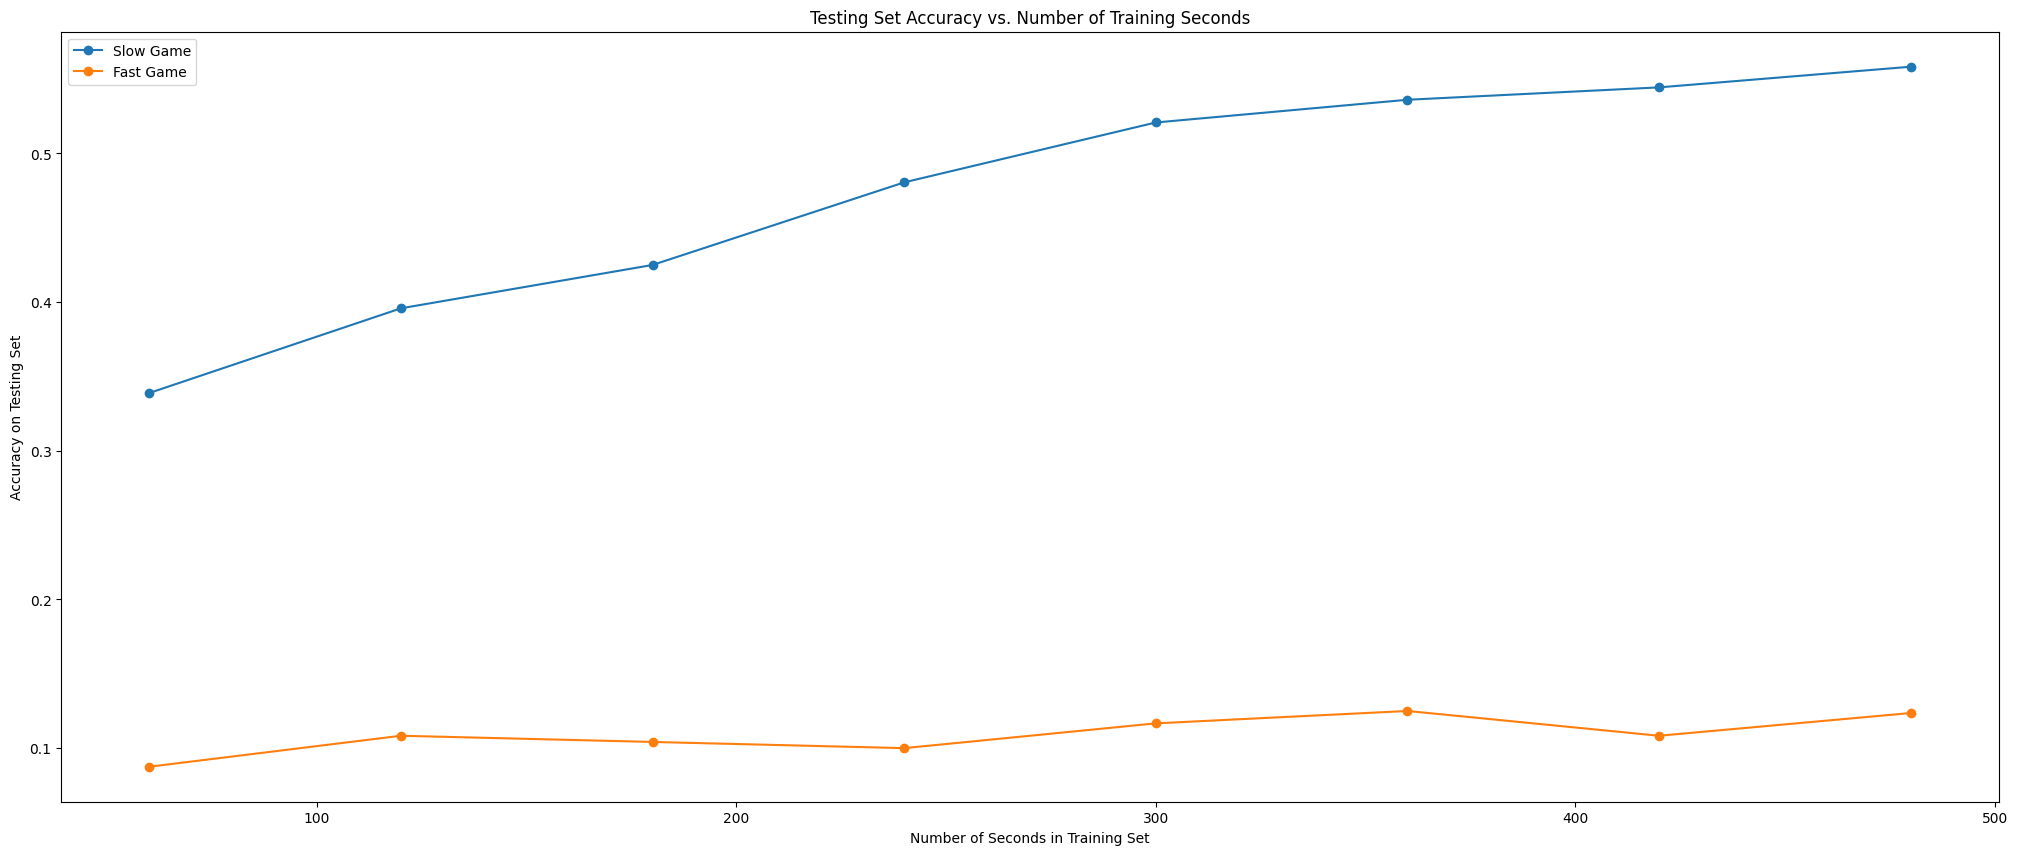


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.338889,0.087500
1,120,0.395833,0.108333
2,180,0.425000,0.104167
3,240,0.480556,0.100000
4,300,0.520833,0.116667
5,360,0.536111,0.125000
6,420,0.544444,0.108333
7,480,0.558333,0.123611


In [21]:
evaluator.accuracy_over_time(X, y,best_model_slow_name, range(1,9), X_test, y_test, fX_test, fy_test)

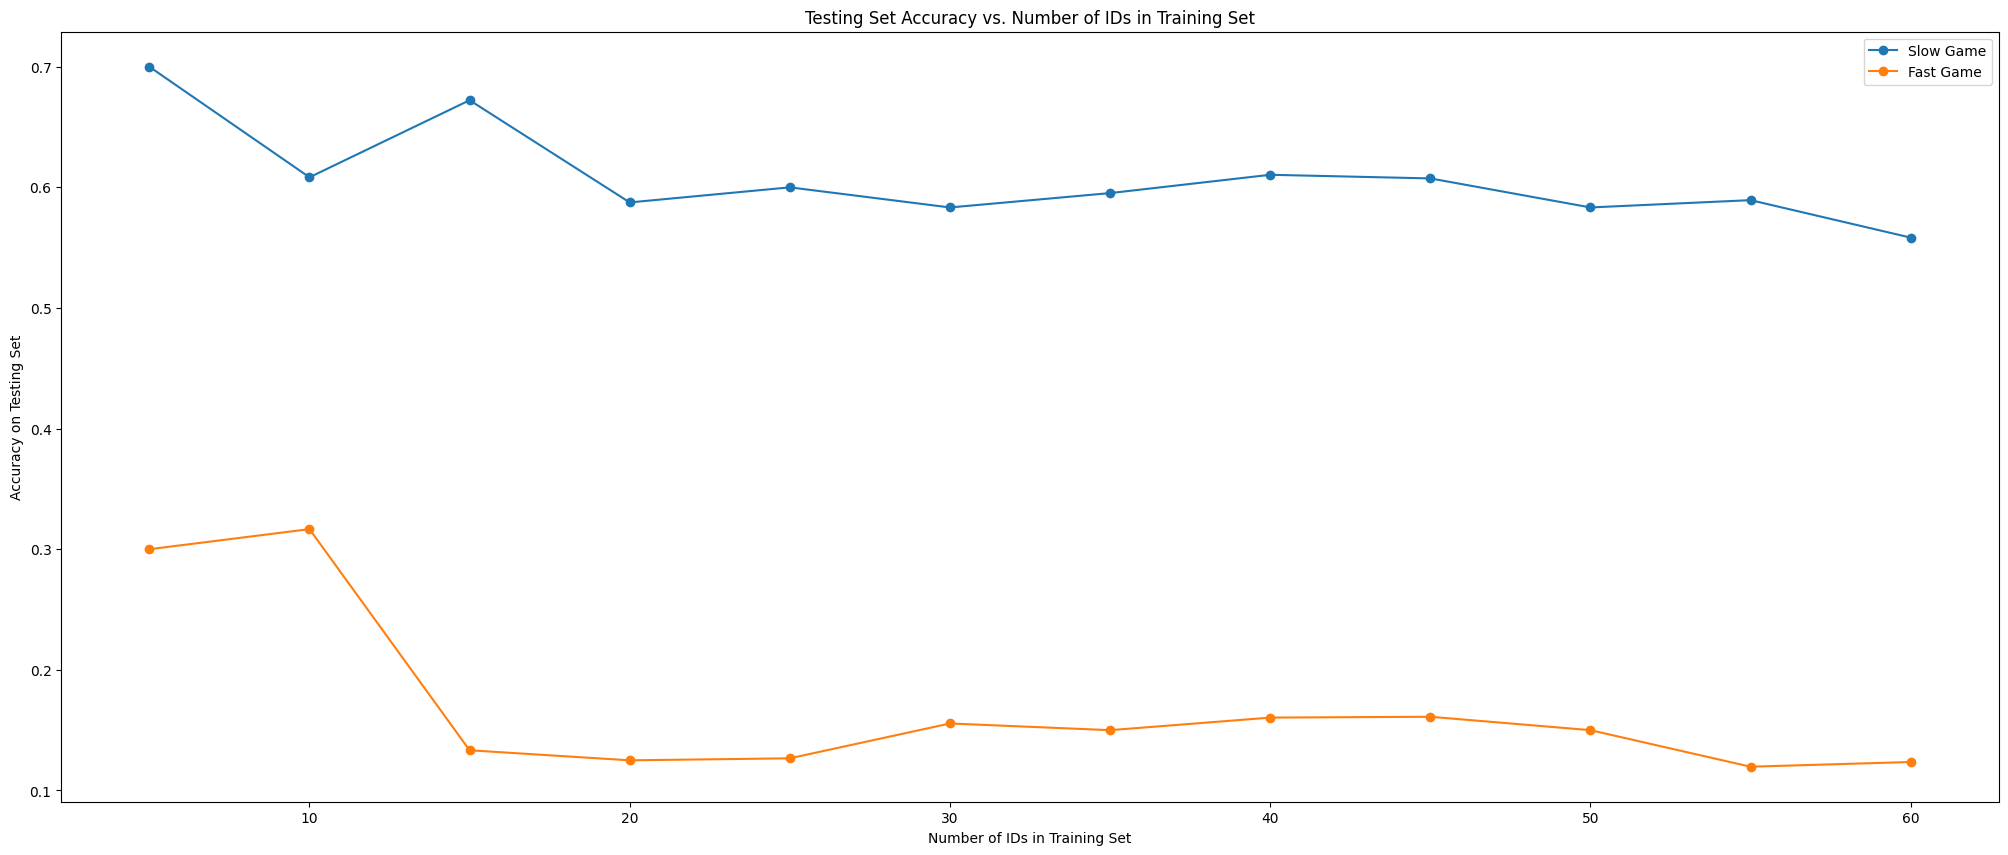


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,0.700000,0.300000
1,10,0.608333,0.316667
2,15,0.672222,0.133333
3,20,0.587500,0.125000
4,25,0.600000,0.126667
5,30,0.583333,0.155556
6,35,0.595238,0.150000
7,40,0.610417,0.160417
8,45,0.607407,0.161111
9,50,0.583333,0.150000


In [22]:
evaluator.accuracy_over_ids(X_train, y_train, best_model_slow_name,  X_test, y_test,fX_test, fy_test)

## 3.3 Combining Movment and Traffic Data

Size of the training set:  (2879, 28)
Size of the slow testing set:  (720, 28)
Size of the fast training set:  (2880, 28)
Size of the fast testing set:  (720, 28)

In [23]:
# Concatenate movement and traffic data for both slow and fast datasets
mov_combined = pd.concat([mov_slow, traffic_slow.drop(columns=['time_interval','ID'])], axis=1).dropna()
fast_combined = pd.concat([mov_fast, traffic_fast.drop(columns=['time_interval','ID'])], axis=1).dropna()
unique_minutes = list(range(1,11))
# Prepare combined data
X_combined = mov_combined.drop(columns=['ID', 'time_interval'])
y_combined = mov_combined['ID']
fX_combined = fast_combined.drop(columns=['ID', 'time_interval'])
fy_combined = fast_combined['ID']

# Split combined data
X_train = X_combined[mov_combined['time_interval'].isin(unique_minutes[:8])]
y_train = y_combined[mov_combined['time_interval'].isin(unique_minutes[:8])]
X_test = X_combined[mov_combined['time_interval'].isin(unique_minutes[8:10])]
y_test = y_combined[mov_combined['time_interval'].isin(unique_minutes[8:10])]

fX_train = fX_combined[fast_combined['time_interval'].isin(unique_minutes[:8])]
fy_train = fy_combined[fast_combined['time_interval'].isin(unique_minutes[:8])]
fX_test = fX_combined[fast_combined['time_interval'].isin(unique_minutes[8:10])]
fy_test = fy_combined[fast_combined['time_interval'].isin(unique_minutes[8:10])]

# Verify sizes
print("Size of the combined slow training set: ", X_train.shape)
print("Size of the combined slow testing set: ", X_test.shape)
print("Size of the combined fast training set: ", fX_train.shape)
print("Size of the combined fast testing set: ", fX_test.shape)

print("Size of the combined slow training labels: ", y_train.shape)
print("Size of the combined slow testing labels: ", y_test.shape)
print("Size of the combined fast training labels: ", fy_train.shape)
print("Size of the combined fast testing labels: ", fy_test.shape)


Size of the combined slow training set:  (2877, 490)
Size of the combined slow testing set:  (720, 490)
Size of the combined fast training set:  (2880, 490)
Size of the combined fast testing set:  (720, 490)
Size of the combined slow training labels:  (2877,)
Size of the combined slow testing labels:  (720,)
Size of the combined fast training labels:  (2880,)
Size of the combined fast testing labels:  (720,)


In [24]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(X_train,y_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Slow)').style.background_gradient(cmap= plt.cm.Blues)

100%|██████████| 15/15 [11:53<00:00, 47.57s/it] 


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),Precision(Train),Precision(Slow),Recall(Train),Recall(Slow),Log_loss(Train),Log_loss(Slow)
11,BernoulliNB,0.076121,0.045833,0.027778,0.076121,0.045833,0.076121,0.045833,0.076121,0.045833,3.957054,4.097519
9,QuadraticDiscriminantAnalysis,1.000000,0.051389,0.018056,1.000000,0.051389,1.000000,0.051389,1.000000,0.051389,0.000000,34.191410
7,AdaBoostClassifier,0.089677,0.086111,0.016667,0.089677,0.086111,0.089677,0.086111,0.089677,0.086111,3.265681,3.276105
0,SVC,0.680222,0.640278,0.056944,0.680222,0.640278,0.680222,0.640278,0.680222,0.640278,4.095256,4.094944
4,KNeighborsClassifier,0.925269,0.756944,0.047222,0.925269,0.756944,0.925269,0.756944,0.925269,0.756944,0.213819,4.382194
8,GaussianNB,0.916927,0.783333,0.016667,0.916927,0.783333,0.916927,0.783333,0.916927,0.783333,2.264860,7.023660
3,DecisionTreeClassifier,1.000000,0.801389,0.061111,1.000000,0.801389,1.000000,0.801389,1.000000,0.801389,0.000000,7.158670
6,MLPClassifier,0.991658,0.865278,0.031944,0.991658,0.865278,0.991658,0.865278,0.991658,0.865278,0.080574,0.553019
12,BaggingClassifier,0.998610,0.866667,0.047222,0.998610,0.866667,0.998610,0.866667,0.998610,0.866667,0.064826,1.661977
10,LogisticRegression,0.984706,0.870833,0.029167,0.984706,0.870833,0.984706,0.870833,0.984706,0.870833,0.323290,0.595423


In [25]:
explainer = shap.TreeExplainer(best_model_slow)
shap_values_slow = explainer.shap_values(X_test)
shap_values_fast = explainer.shap_values(fX_test)

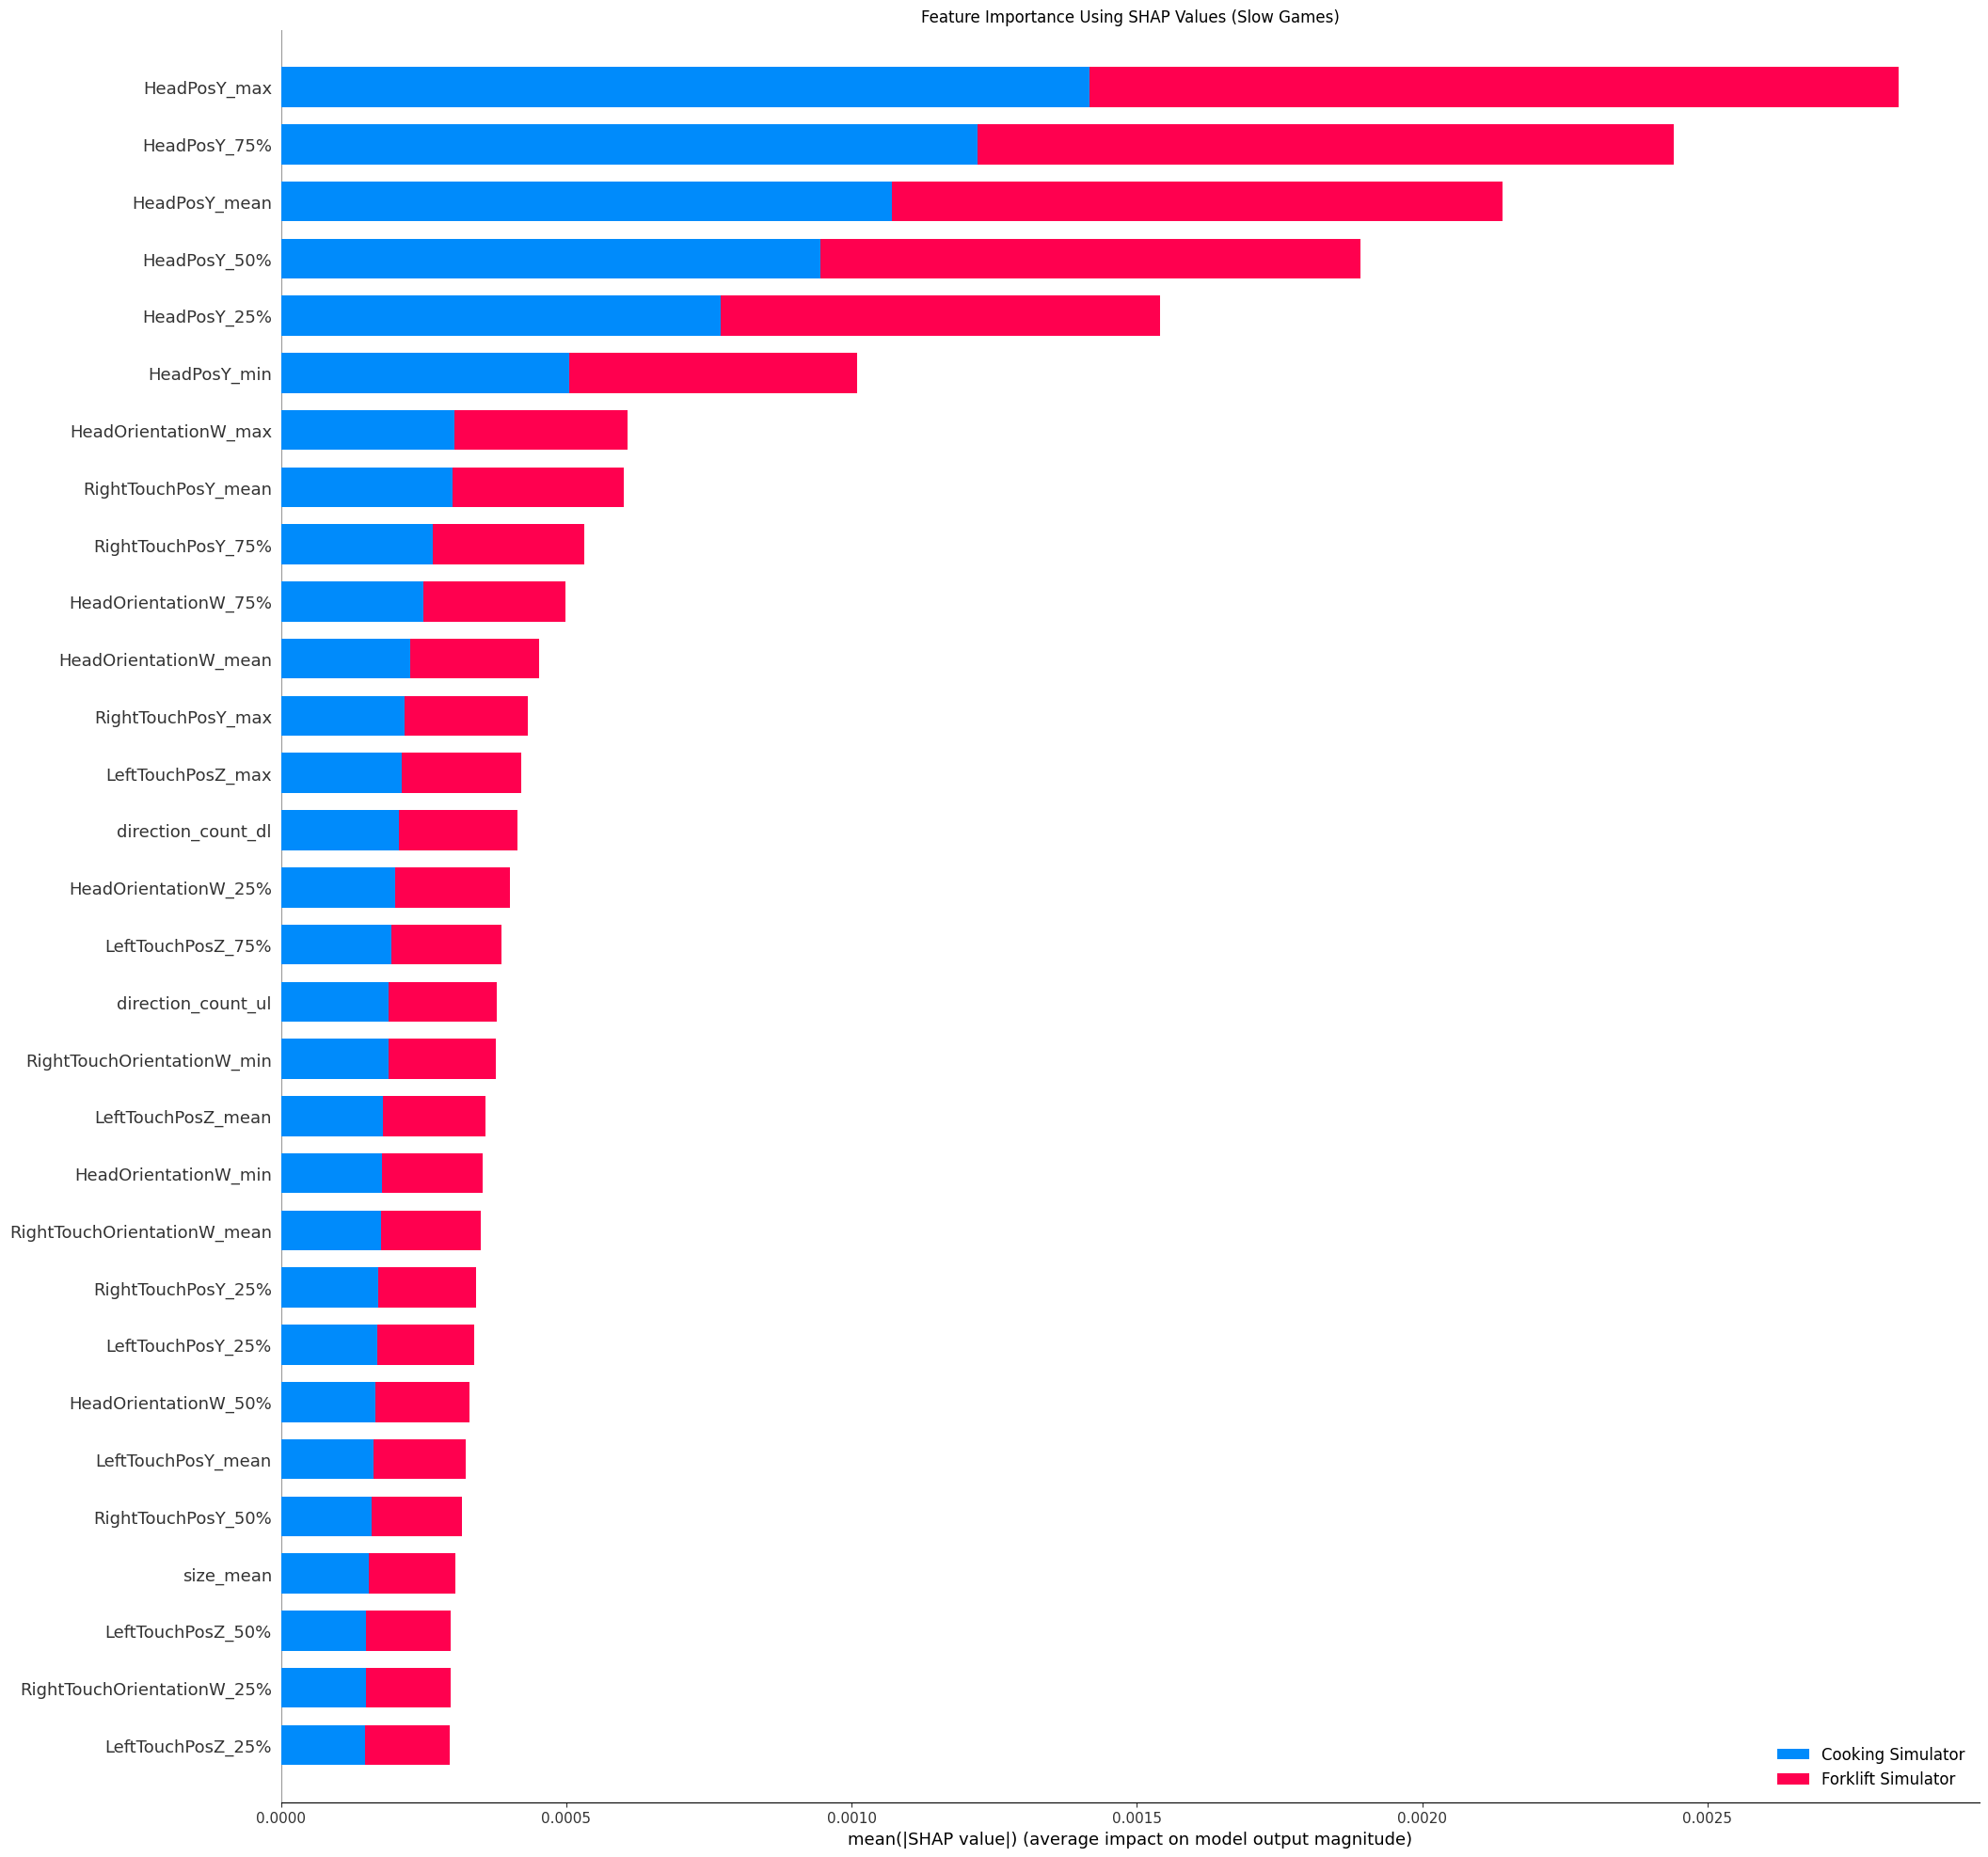

In [26]:
VisualizationUtils.shap_plotter([np.mean(shap_values_slow[:,:,:30], axis=2), np.mean(shap_values_slow[:,:,30:], axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (Slow Games)",
                          class_names=['Cooking Simulator', 'Forklift Simulator'])

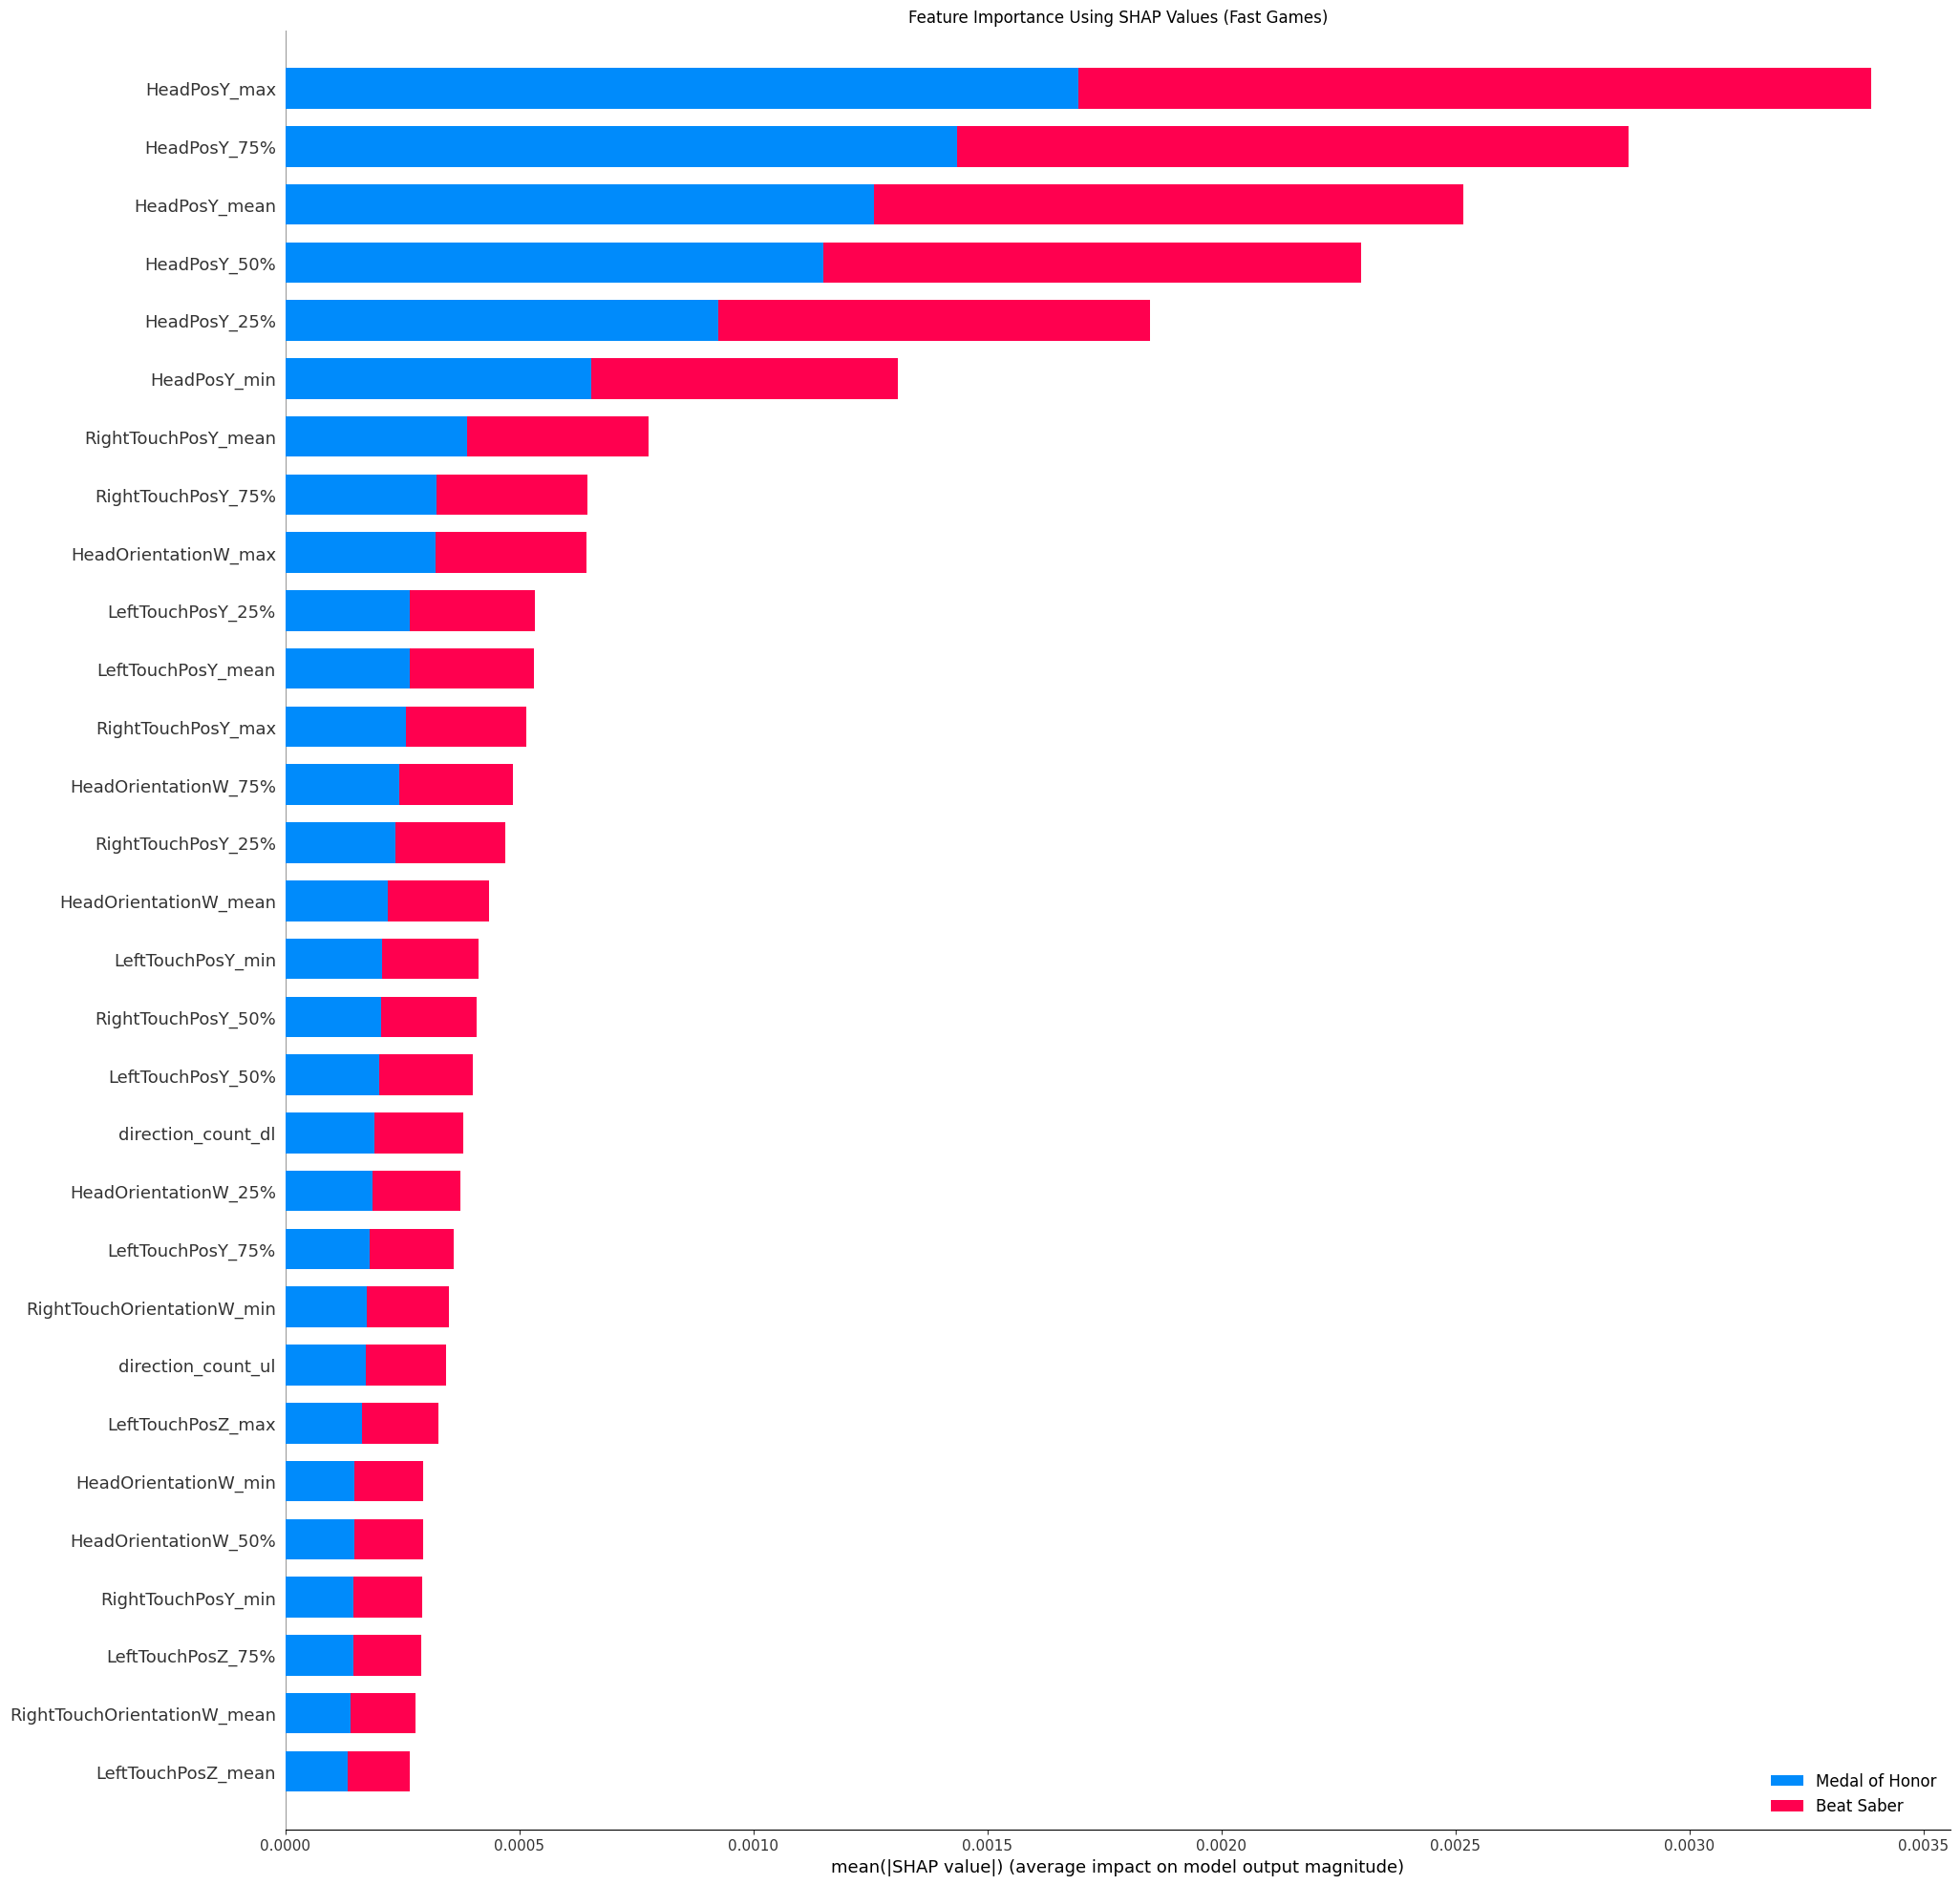

In [27]:
VisualizationUtils.shap_plotter([np.mean(shap_values_fast[:,:,:30], axis=2), np.mean(shap_values_fast[:,:,30:], axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (Fast Games)",
                          class_names=['Beat Saber', 'Medal of Honor'])

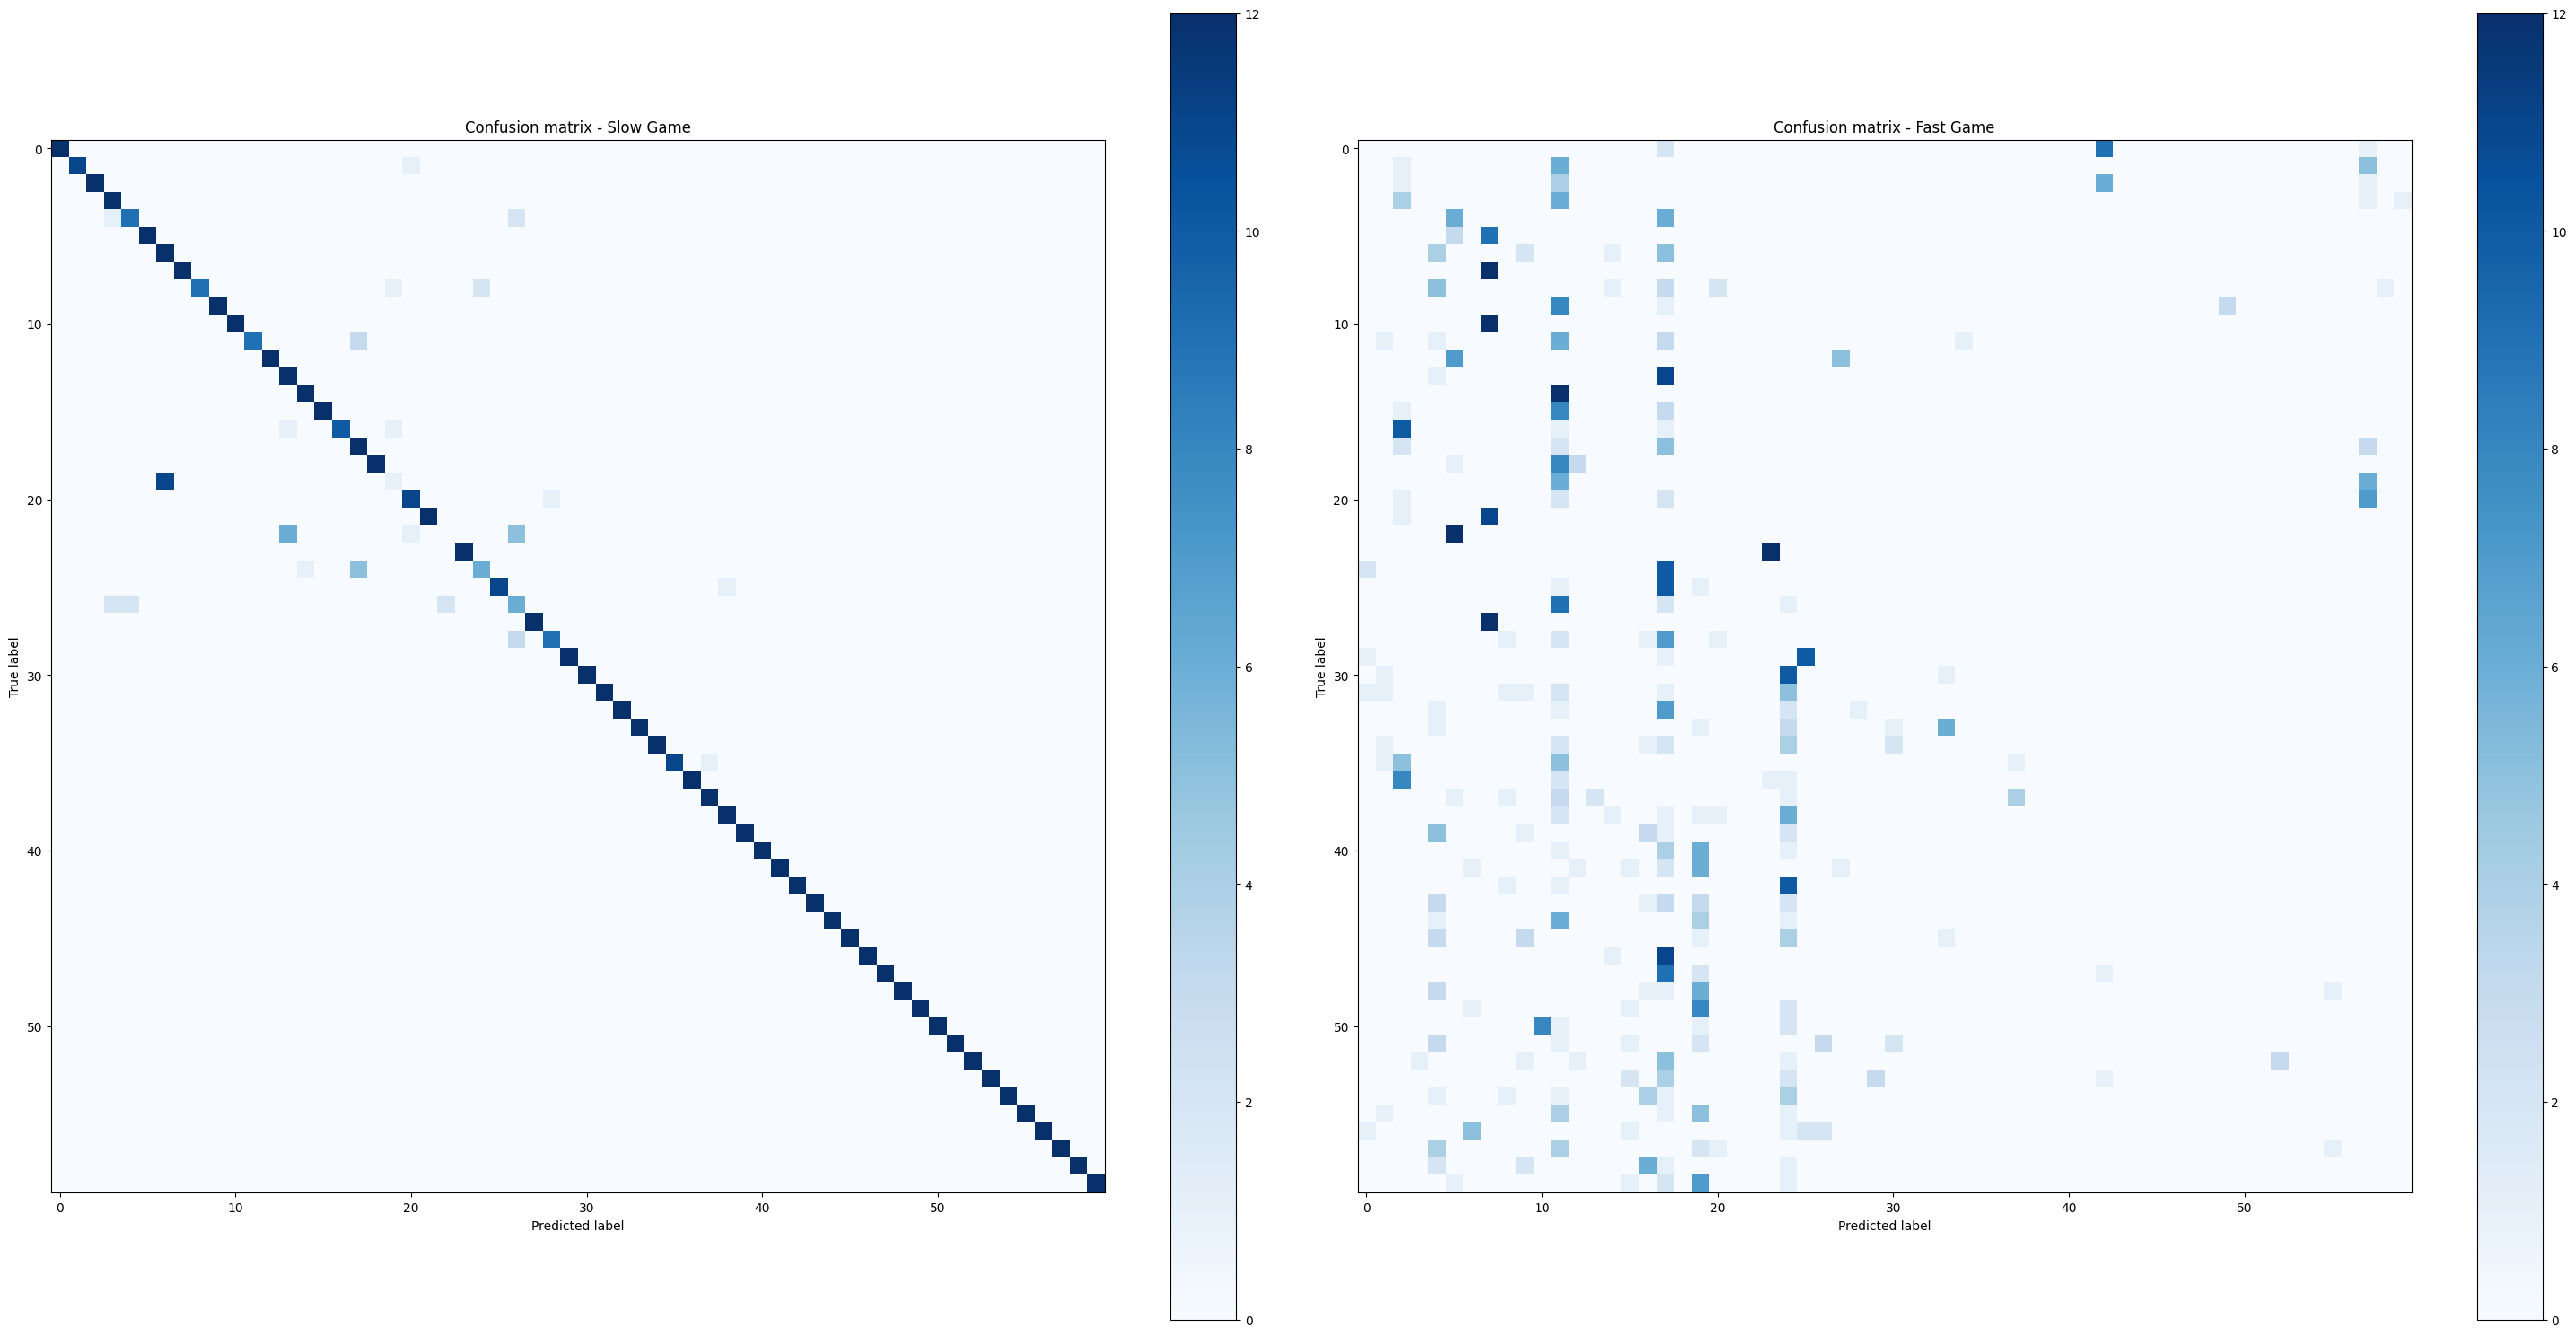

In [28]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

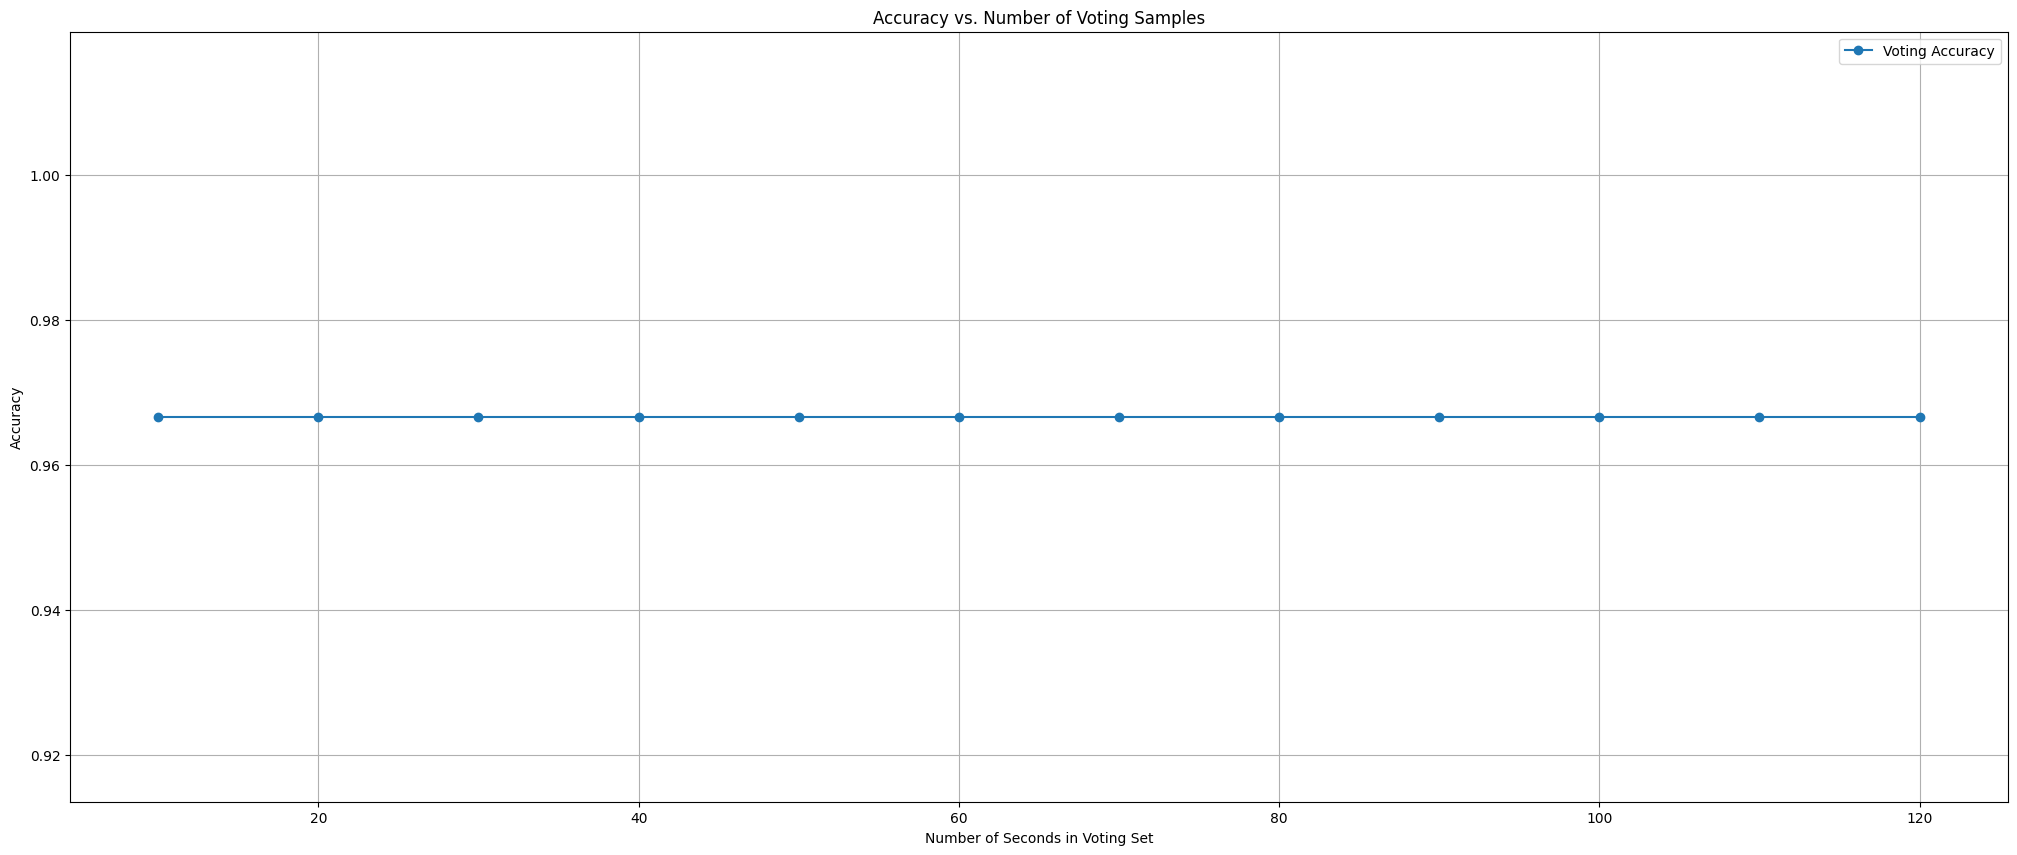


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.966667
1,20,0.966667
2,30,0.966667
3,40,0.966667
4,50,0.966667
5,60,0.966667
6,70,0.966667
7,80,0.966667
8,90,0.966667
9,100,0.966667


In [29]:
evaluator.plot_accuracy_by_vote(best_model_slow, X_test, y_test, increment=1)

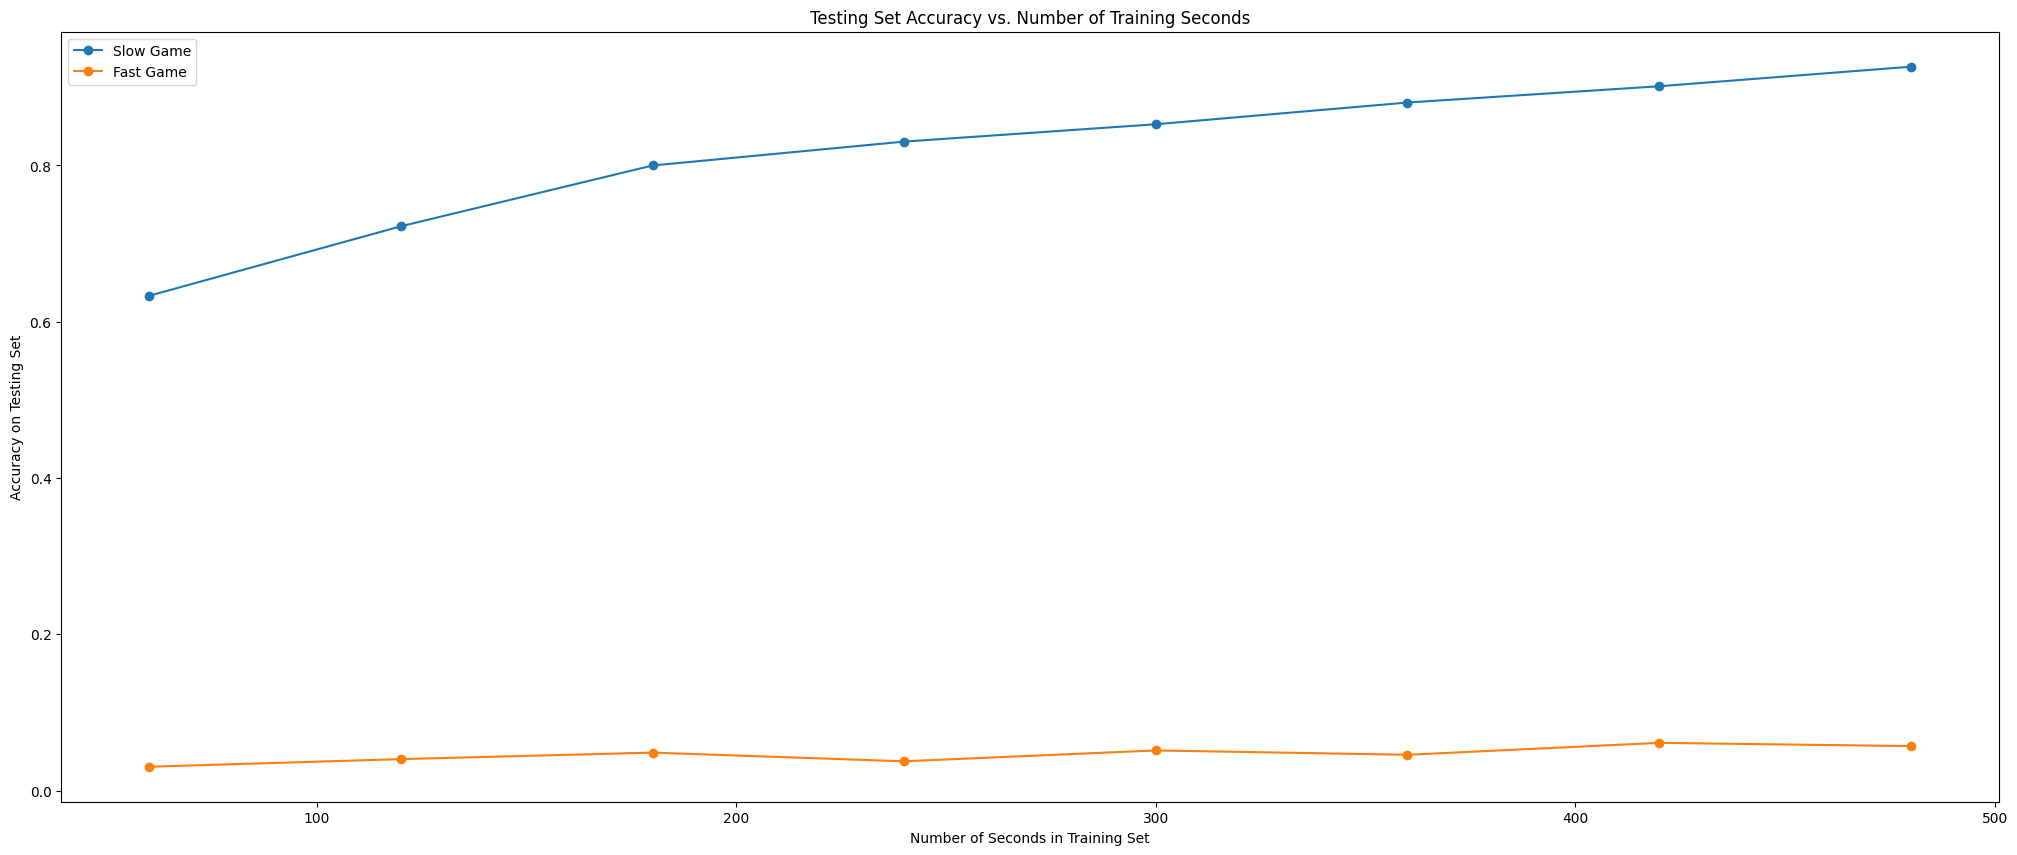


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.633333,0.030556
1,120,0.722222,0.040278
2,180,0.800000,0.048611
3,240,0.830556,0.037500
4,300,0.852778,0.051389
5,360,0.880556,0.045833
6,420,0.901389,0.061111
7,480,0.926389,0.056944


In [32]:
X = mov_combined.drop(columns=['ID'])
y = mov_combined['ID']
evaluator.accuracy_over_time(X, y,best_model_slow_name, range(1,9), X_test, y_test, fX_test, fy_test)

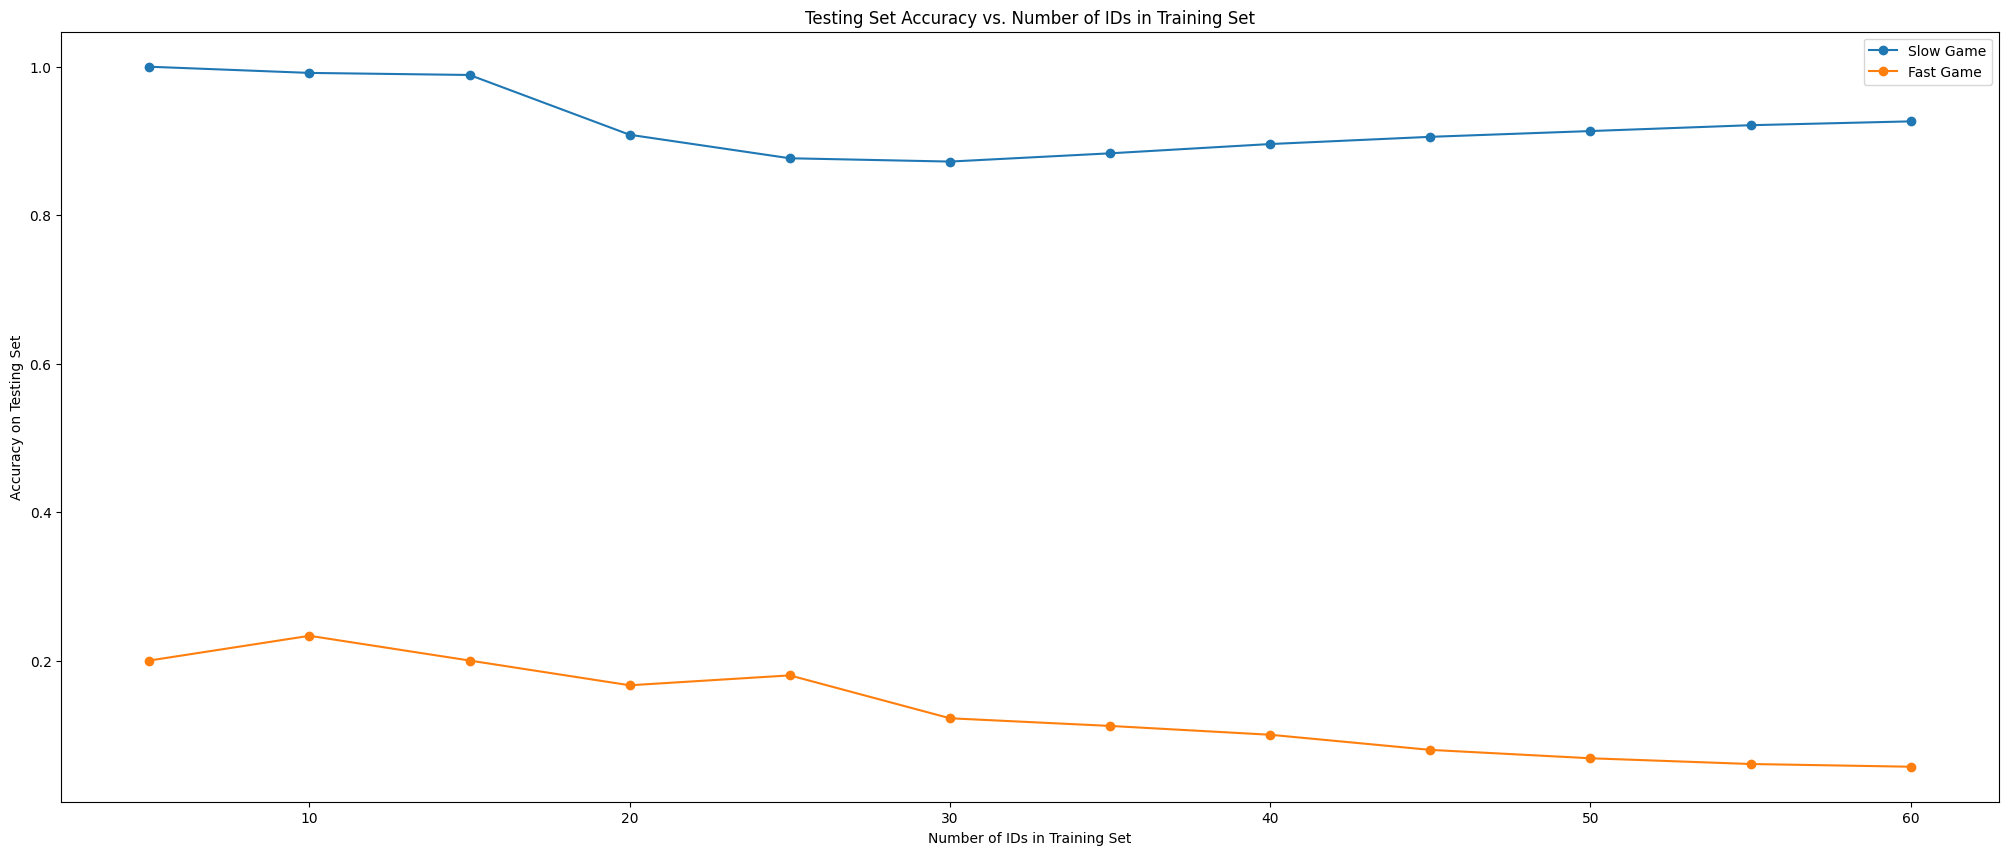


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,1.000000,0.200000
1,10,0.991667,0.233333
2,15,0.988889,0.200000
3,20,0.908333,0.166667
4,25,0.876667,0.180000
5,30,0.872222,0.122222
6,35,0.883333,0.111905
7,40,0.895833,0.100000
8,45,0.905556,0.079630
9,50,0.913333,0.068333


In [33]:
evaluator.accuracy_over_ids(X_train, y_train, best_model_slow_name,  X_test, y_test,fX_test, fy_test)